<a href="https://colab.research.google.com/github/namira24-007/python-course/blob/master/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow tensorflow-addons numpy matplotlib opencv-python keras-facenet
!pip install --upgrade typeguard inflect
!pip install tensorflow==2.15.0 tensorflow-addons

import tensorflow as tf
import numpy as np
import os
import cv2
import random
import matplotlib.pyplot as plt
from keras_facenet import FaceNet
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_addons as tfa


  Using cached typeguard-4.4.2-py3-none-any.whl.metadata (3.8 kB)
Using cached typeguard-4.4.2-py3-none-any.whl (35 kB)
  Attempting uninstall: typeguard
    Found existing installation: typeguard 2.13.3
    Uninstalling typeguard-2.13.3:
      Successfully uninstalled typeguard-2.13.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-addons 0.23.0 requires typeguard<3.0.0,>=2.7, but you have typeguard 4.4.2 which is incompatible.
  Using cached typeguard-2.13.3-py3-none-any.whl.metadata (3.6 kB)
Using cached typeguard-2.13.3-py3-none-any.whl (17 kB)
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.2
    Uninstalling typeguard-4.4.2:
      Successfully uninstalled typeguard-4.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the 

/usr/local/lib/python3.11/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Step 2: Load Dataset & Preprocessing

In [2]:
# Mount Google Drive (if using Colab)
import os
from google.colab import drive
drive.mount('/content/drive')

# Define dataset paths
DATASET_PATH = "/content/drive/MyDrive/Namira/CUHK_dataset/"
PHOTOS_DIR = os.path.join(DATASET_PATH, "Photos")
SKETCHES_DIR = os.path.join(DATASET_PATH, "Sketches")

# Verify dataset existence
for directory in [PHOTOS_DIR, SKETCHES_DIR]:
    if not os.path.exists(directory):
        raise FileNotFoundError(f"❌ Directory not found: {directory}")

print("✅ Dataset paths verified!")

# Parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EMBEDDING_DIM = 128


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Dataset paths verified!


Step 3: Custom Data Generator with Augmentation

In [3]:
import tensorflow as tf  # ✅ Add this line
import os
class SketchPhotoGenerator(tf.keras.utils.Sequence):
    def __init__(self, photo_dir, sketch_dir, batch_size=32, shuffle=True, augment=True):
        self.photo_paths = [os.path.join(photo_dir, f) for f in os.listdir(photo_dir)]
        self.sketch_paths = [os.path.join(sketch_dir, f) for f in os.listdir(sketch_dir)]
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.photo_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_photos = []
        batch_sketches = []

        for i in range(index * self.batch_size, (index + 1) * self.batch_size):
            # Load and preprocess images
            photo = cv2.imread(self.photo_paths[i])
            photo = cv2.cvtColor(photo, cv2.COLOR_BGR2RGB)
            photo = cv2.resize(photo, (IMG_SIZE, IMG_SIZE)) / 255.0

            sketch = cv2.imread(self.sketch_paths[i], cv2.IMREAD_GRAYSCALE)
            sketch = cv2.cvtColor(sketch, cv2.COLOR_GRAY2RGB)
            sketch = cv2.resize(sketch, (IMG_SIZE, IMG_SIZE)) / 255.0

            # Apply data augmentation
            if self.augment:
                if random.random() > 0.5:
                    photo = np.fliplr(photo)
                    sketch = np.fliplr(sketch)
                if random.random() > 0.5:
                    photo = np.flipud(photo)
                    sketch = np.flipud(sketch)

            batch_photos.append(photo)
            batch_sketches.append(sketch)

        return np.array(batch_sketches), np.array(batch_photos)

train_gen = SketchPhotoGenerator(PHOTOS_DIR, SKETCHES_DIR, batch_size=BATCH_SIZE)
print("✅ Data generator initialized with augmentation!")


✅ Data generator initialized with augmentation!


Step 4: Optimized CNN Model (EfficientNet)

In [4]:
# ✅ Step 3: Model Architecture
!apt-get install graphviz -y  # Ensure Graphviz is installed
!pip install pydot graphviz  # Install necessary Python libraries
import os
import random
import cv2
import numpy as np
import tensorflow as tf
from keras_facenet import FaceNet
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model


# ✅ Define dataset paths
dataset_path = "/content/drive/MyDrive/Namira/CUHK_dataset/"
photos_dir = os.path.join(dataset_path, "Photos")
sketches_dir = os.path.join(dataset_path, "Sketches")

# ✅ Verify dataset paths
if not os.path.exists(photos_dir):
    raise FileNotFoundError(f"❌ Photos directory NOT found: {photos_dir}")
if not os.path.exists(sketches_dir):
    raise FileNotFoundError(f"❌ Sketches directory NOT found: {sketches_dir}")
print("✅ Dataset paths verified!")

# ✅ Define Model Architecture
embedder = FaceNet()
IMG_SIZE = 224
EMBEDDING_DIM = 128

from tensorflow.keras.applications import EfficientNetB3

def create_embedding_model():
    base_model = EfficientNetB3(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    embeddings = tf.keras.layers.Dense(128, activation=None, name='embeddings')(x)

    model = tf.keras.Model(inputs=base_model.input, outputs=embeddings)
    return model

# Create model
embedding_model = create_embedding_model()
embedding_model.summary()
print("✅ EfficientNet-based model created!")


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.
✅ Dataset paths verified!
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_2[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                         

In [5]:
# Before calling plot_model
import os
os.environ["PATH"] += os.pathsep + '/usr/bin/dot' # Add path to Graphviz's 'dot' executable
# Update the path according to your system's configuration

# ✅ Save model architecture as an image
try:
    plot_model(embedding_model, to_file="embedding_model.png", show_shapes=True, show_layer_names=True)
    print("✅ Model architecture saved as 'embedding_model.png'")
except Exception as e:
    print(f"⚠️ Warning: Could not generate model plot due to error: {e}")

# ✅ Test Model Output with a Sample Image
photo_files = os.listdir(photos_dir)
if not photo_files:
    raise FileNotFoundError("❌ No images found in Photos directory!")

sample_image_path = os.path.join(photos_dir, random.choice(photo_files))
sample_image = cv2.imread(sample_image_path)
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
sample_image = cv2.resize(sample_image, (IMG_SIZE, IMG_SIZE)) / 255.0

# Generate embedding
sample_embedding = embedding_model.predict(np.expand_dims(sample_image, axis=0))

# ✅ Print sample output
print("\n🖼 Sample Image Processed from:", sample_image_path)
print("📏 Test Embedding Shape:", sample_embedding.shape)
print("🔢 Test Embedding Values (first 5):", sample_embedding[0][:5])

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.763782 to fit

✅ Model architecture saved as 'embedding_model.png'
1/1 [==============================] - 3s 3s/step

🖼 Sample Image Processed from: /content/drive/MyDrive/Namira/CUHK_dataset/Photos/088.jpg
📏 Test Embedding Shape: (1, 128)
🔢 Test Embedding Values (first 5): [-0.03196424  0.20346881  0.33157665 -0.08638991  0.25520775]


In [6]:
sample_input = np.random.rand(1, IMG_SIZE, IMG_SIZE, 3).astype(np.float32)
sample_output = embedding_model(sample_input)

print("✅ Model Output Shape:", sample_output.shape)  # Expected: (1, EMBEDDING_DIM)

✅ Model Output Shape: (1, 128)


In [7]:
batch_sketches, batch_photos = next(iter(train_gen))
print("✅ Batch Shapes:", batch_sketches.shape, batch_photos.shape)  # Expected: (batch_size, IMG_SIZE, IMG_SIZE, 3)

✅ Batch Shapes: (32, 224, 224, 3) (32, 224, 224, 3)


Step 5: Triplet Loss for Better Face Matching

In [8]:
def triplet_loss(y_true, y_pred):
    y_pred = tf.reshape(y_pred, (-1, 128))  # Ensure correct shape
    return tfa.losses.TripletSemiHardLoss(margin=0.3)(y_true, y_pred)  # Optimized margin

# Compile model
embedding_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=triplet_loss)
print("✅ Model compiled with Triplet Loss!")


✅ Model compiled with Triplet Loss!


Step 6: Train the Model

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# ✅ Define Embedding Model (Example: Simple CNN + Dense Layers)
def build_embedding_model():
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(224, 224, 3),
        include_top=False,
        pooling='avg'
    )

    # Create embedding output
    embedding_output = layers.Dense(128, activation=None)(base_model.output)
    embedding_model = Model(inputs=base_model.input, outputs=embedding_output)

    return embedding_model

# ✅ Initialize Embedding Model
embedding_model = build_embedding_model()
print("✅ Embedding model created!")


✅ Embedding model created!


In [10]:
# ✅ Import necessary libraries
import cv2  # OpenCV for image processing
import os
import numpy as np
import tensorflow as tf

# ✅ Make sure OpenCV is available before using it
print(f"✅ OpenCV version: {cv2.__version__}")


✅ OpenCV version: 4.11.0


In [40]:
import tensorflow as tf
import tensorflow_addons as tfa
import glob
import numpy as np
import cv2
import os

# ✅ Define Paths (Make sure these paths exist and contain images)
sketch_path = "/content/drive/MyDrive/Namira/CUHK_dataset/Sketches"
photo_path = "/content/drive/MyDrive/Namira/CUHK_dataset/Photos"

# ✅ Load image files manually
sketch_files = glob.glob(sketch_path + "/*.jpg")  # Adjust file format if needed
photo_files = glob.glob(photo_path + "/*.jpg")

# ✅ Ensure the number of sketches matches the number of photos
num_samples = min(len(sketch_files), len(photo_files))
sketch_files = sketch_files[:num_samples]
photo_files = photo_files[:num_samples]

print(f"✅ Loaded {len(sketch_files)} sketches and {len(photo_files)} photos.")

# ✅ Function to load and preprocess images
def load_and_preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (160, 160))
    img = img / 255.0  # Normalize
    return img

# ✅ Load all images into NumPy arrays
sketches = np.array([load_and_preprocess_image(f) for f in sketch_files])
photos = np.array([load_and_preprocess_image(f) for f in photo_files])

# ✅ Convert to TensorFlow dataset
train_gen = tf.data.Dataset.from_tensor_slices((sketches, photos))
train_gen = train_gen.shuffle(1000).batch(32, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

print(f"✅ Dataset created with {len(sketches)} samples.")

# ✅ Define the Embedding Model with Correct Output Shape
def create_embedding_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation=None)  # Ensure output shape is (batch_size, 128)
    ])
    return model

embedding_model = create_embedding_model()

# ✅ Triplet Model Wrapper
class TripletModel(tf.keras.Model):
    def __init__(self, embedding_model):
        super(TripletModel, self).__init__()
        self.embedding_model = embedding_model

    def call(self, inputs):
        return self.embedding_model(inputs)

# ✅ Initialize the Triplet Model
triplet_model = TripletModel(embedding_model)

# ✅ Custom Loss to Ensure Correct Reshape
def triplet_loss(y_true, y_pred):
    y_pred = tf.reshape(y_pred, (-1, 128))  # Ensure correct shape
    return tfa.losses.TripletSemiHardLoss()(y_true, y_pred)

# ✅ Compile the Model
embedding_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=triplet_loss)
embedding_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print("✅ Triplet model initialized and compiled!")


✅ Loaded 193 sketches and 193 photos.
✅ Dataset created with 193 samples.
✅ Triplet model initialized and compiled!


In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data augmentation and generator
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = datagen.flow_from_directory( "/content/drive/MyDrive/Namira/CUHK_dataset/",  # Provide the path to your dataset folder
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',  # Adjust based on your labels
    subset='training'
)


Found 310 images belonging to 2 classes.


Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 0.2764

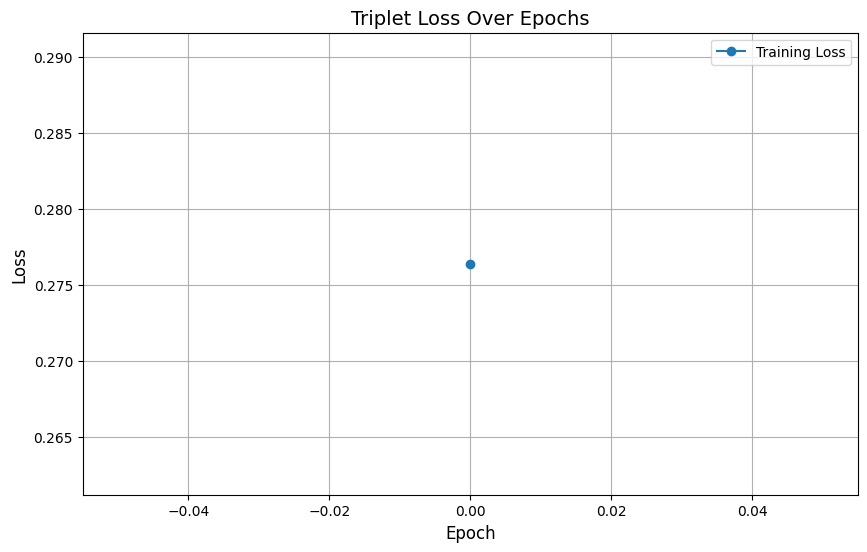

10/10 [==============================] - 38s 4s/step - loss: 0.2764
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 0.1985

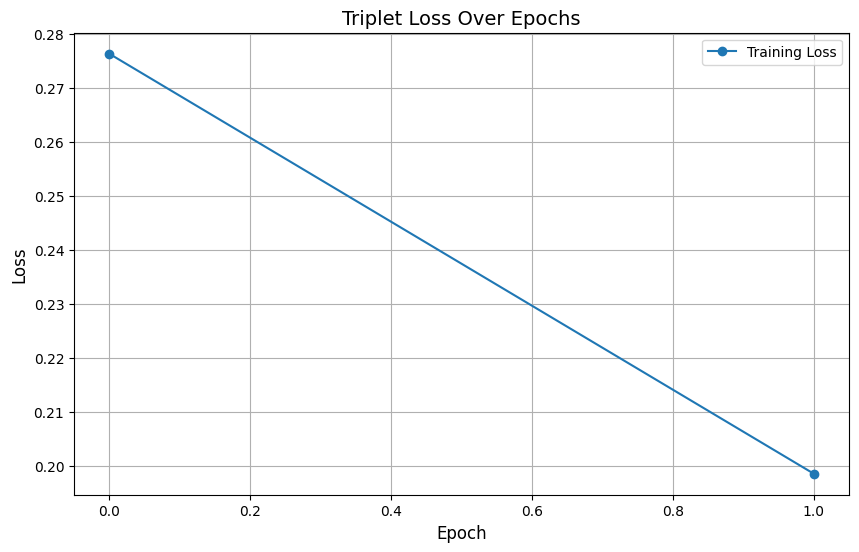

10/10 [==============================] - 26s 3s/step - loss: 0.1985
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.0344

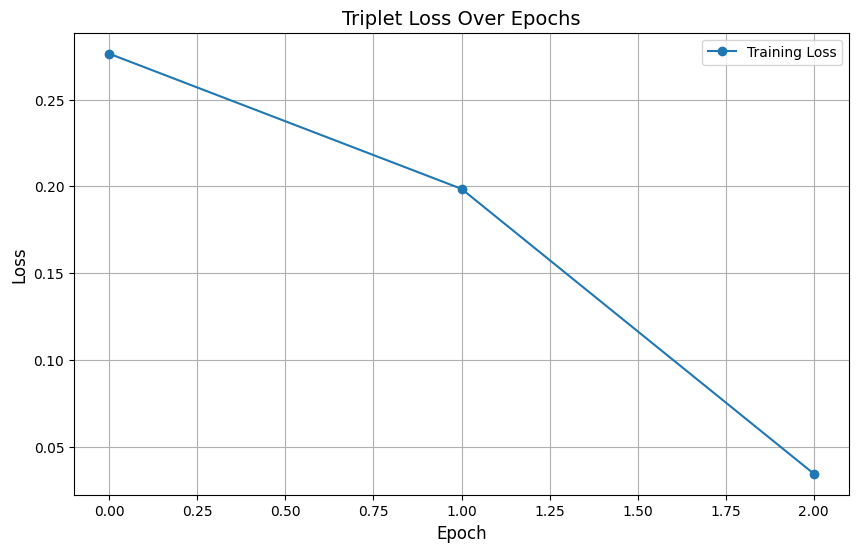

10/10 [==============================] - 25s 2s/step - loss: 0.0344
Epoch 4/100
10/10 [==============================] - ETA: 0s - loss: 0.0071

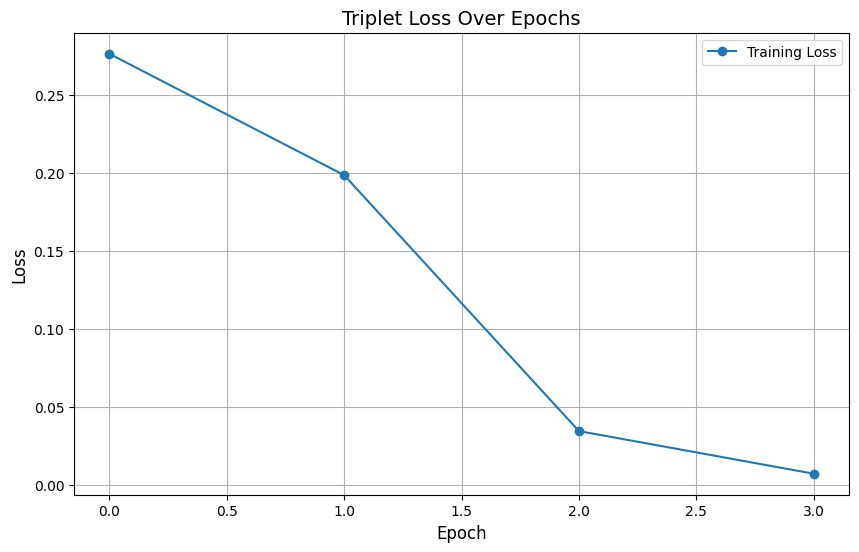

10/10 [==============================] - 24s 2s/step - loss: 0.0071
Epoch 5/100
10/10 [==============================] - ETA: 0s - loss: 0.0656

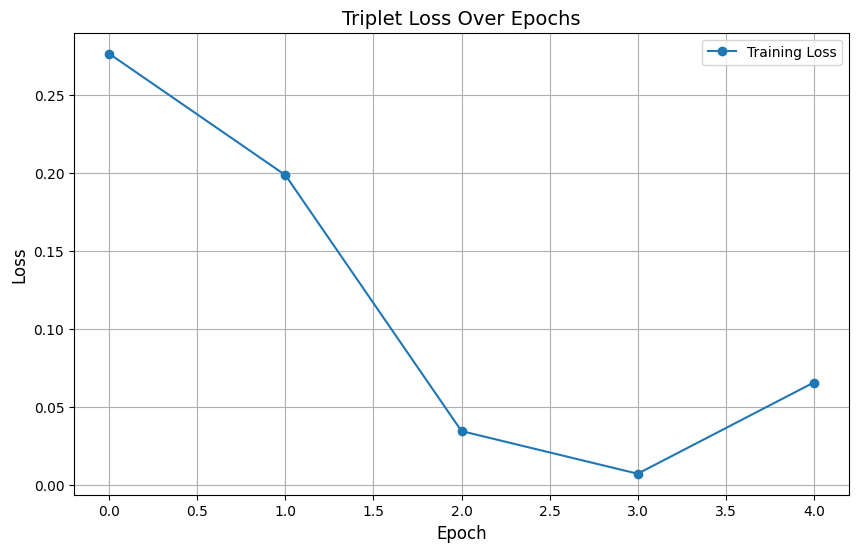

10/10 [==============================] - 23s 2s/step - loss: 0.0656
Epoch 6/100
10/10 [==============================] - ETA: 0s - loss: 0.0189

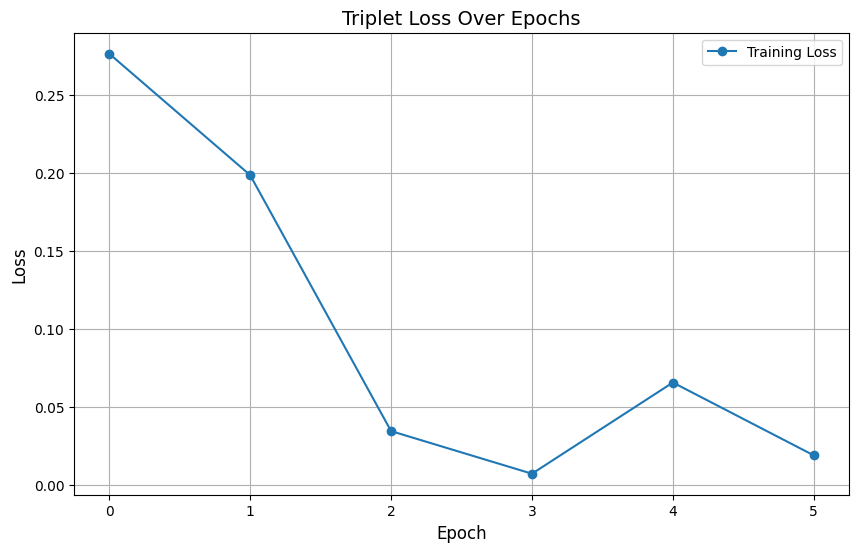

10/10 [==============================] - 25s 2s/step - loss: 0.0189
Epoch 7/100
10/10 [==============================] - ETA: 0s - loss: 0.0037

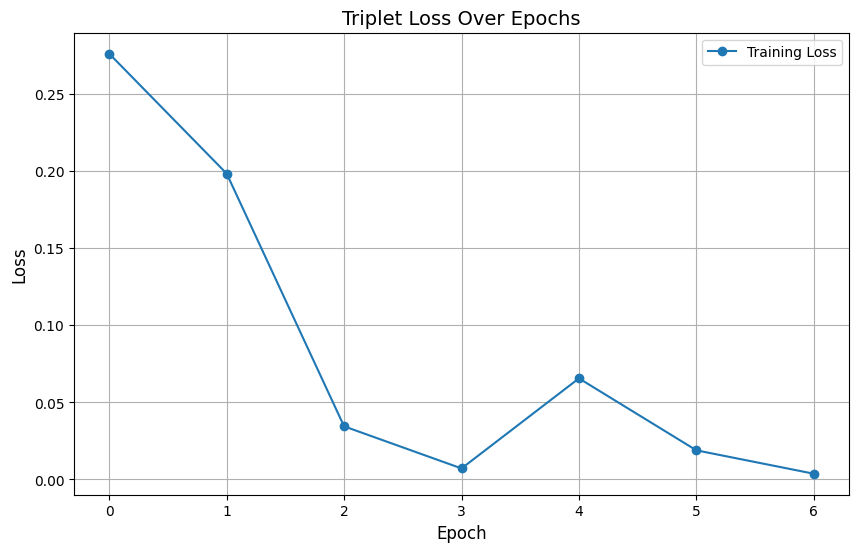

10/10 [==============================] - 25s 2s/step - loss: 0.0037
Epoch 8/100
10/10 [==============================] - ETA: 0s - loss: 0.0016

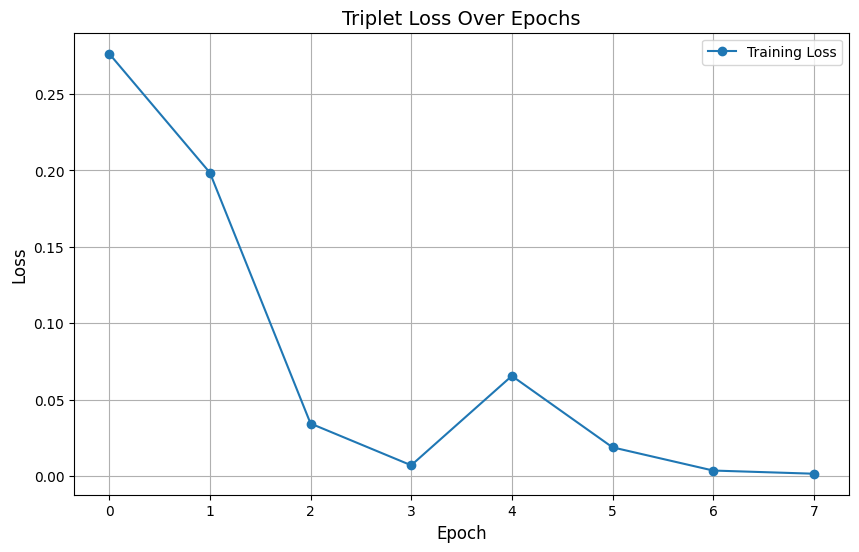

10/10 [==============================] - 25s 2s/step - loss: 0.0016
Epoch 9/100
10/10 [==============================] - ETA: 0s - loss: 1.7460e-04

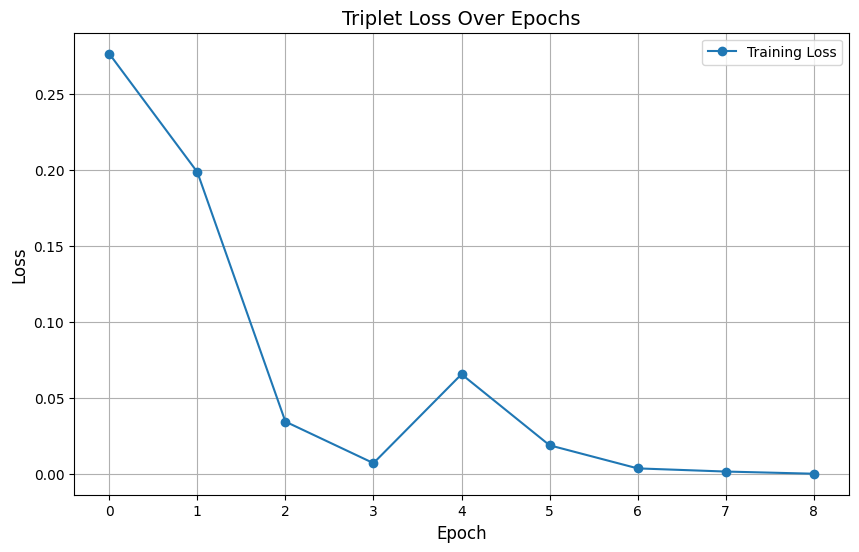

10/10 [==============================] - 24s 2s/step - loss: 1.7460e-04
Epoch 10/100
10/10 [==============================] - ETA: 0s - loss: 0.0012

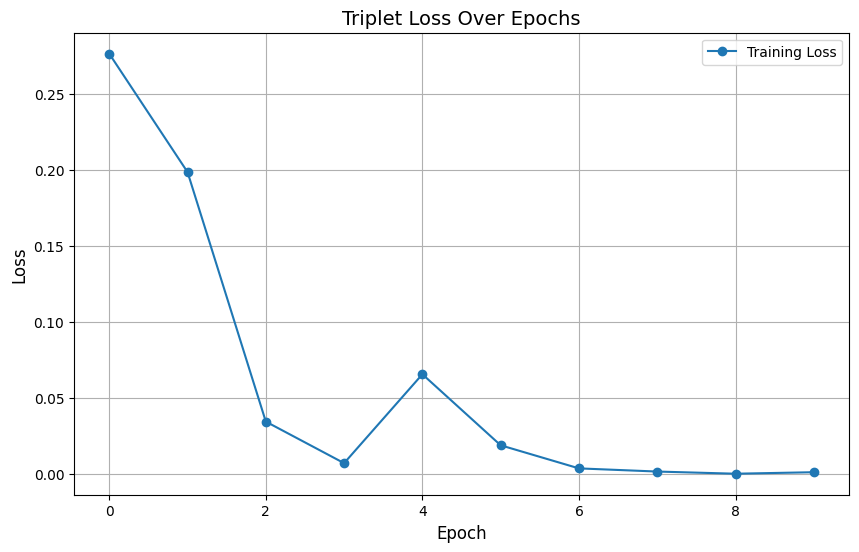

10/10 [==============================] - 25s 3s/step - loss: 0.0012
Epoch 11/100
10/10 [==============================] - ETA: 0s - loss: 0.0011

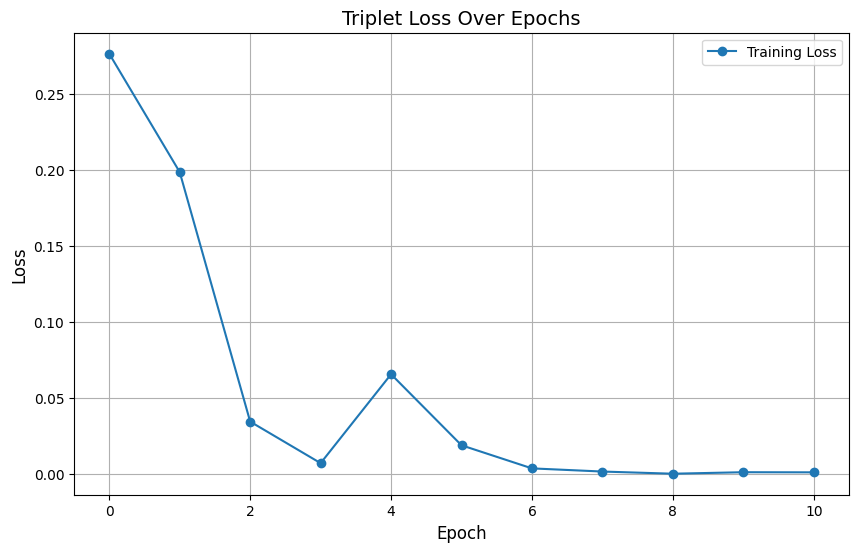

10/10 [==============================] - 23s 2s/step - loss: 0.0011
Epoch 12/100
10/10 [==============================] - ETA: 0s - loss: 0.0114

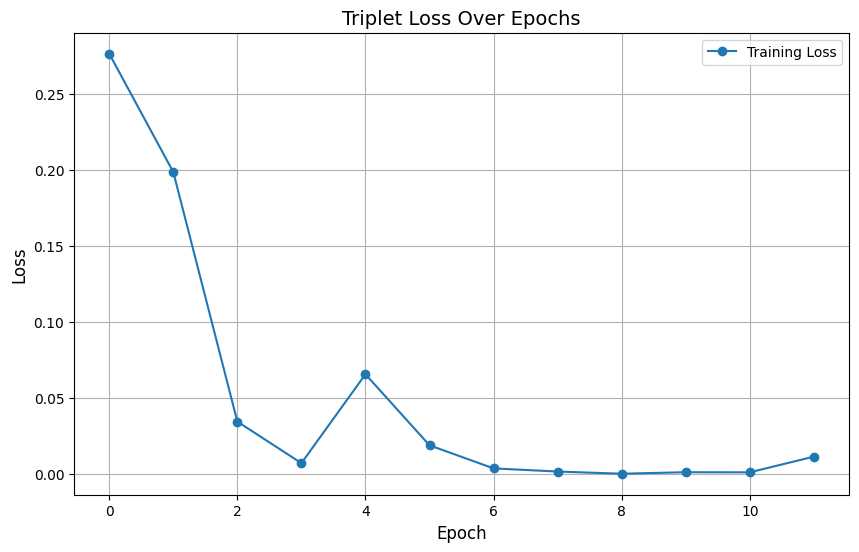

10/10 [==============================] - 25s 2s/step - loss: 0.0114
Epoch 13/100
10/10 [==============================] - ETA: 0s - loss: 0.0026

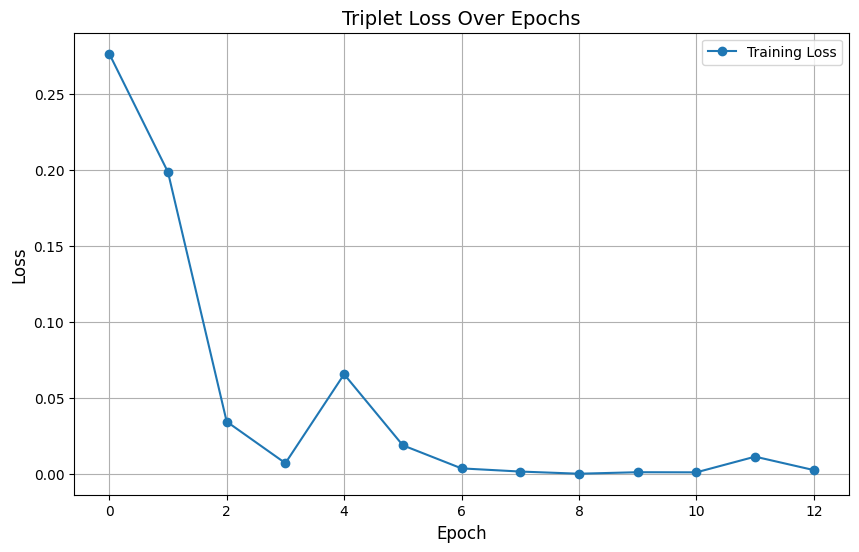

10/10 [==============================] - 25s 2s/step - loss: 0.0026
Epoch 14/100
10/10 [==============================] - ETA: 0s - loss: 5.4686e-04

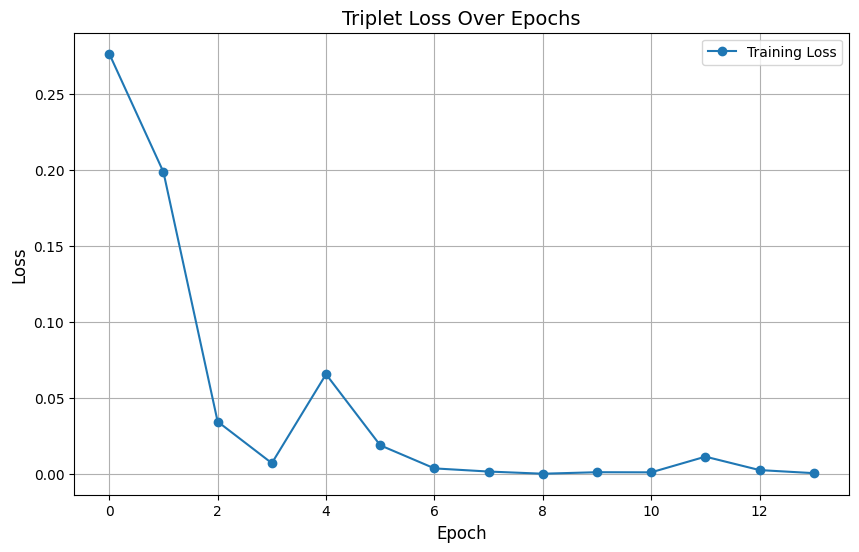

10/10 [==============================] - 25s 3s/step - loss: 5.4686e-04
Epoch 15/100
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00

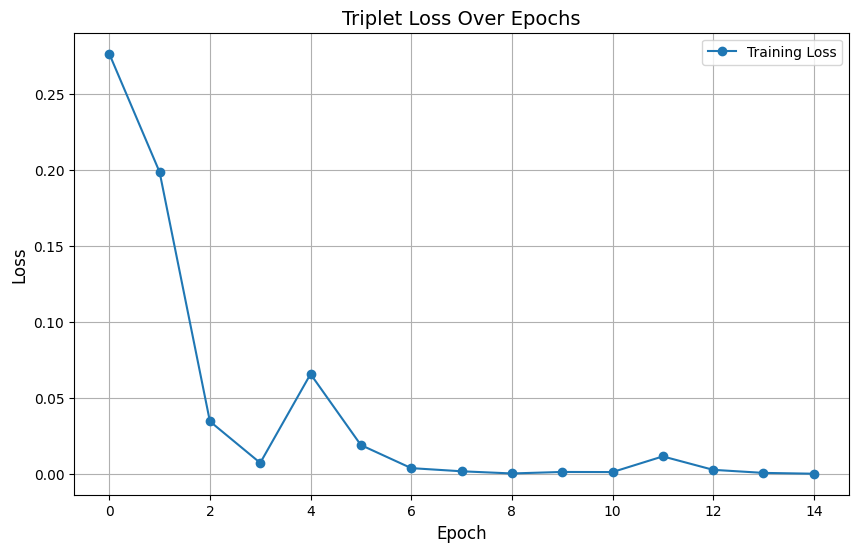

10/10 [==============================] - 24s 2s/step - loss: 0.0000e+00
Epoch 16/100
10/10 [==============================] - ETA: 0s - loss: 6.6731e-05

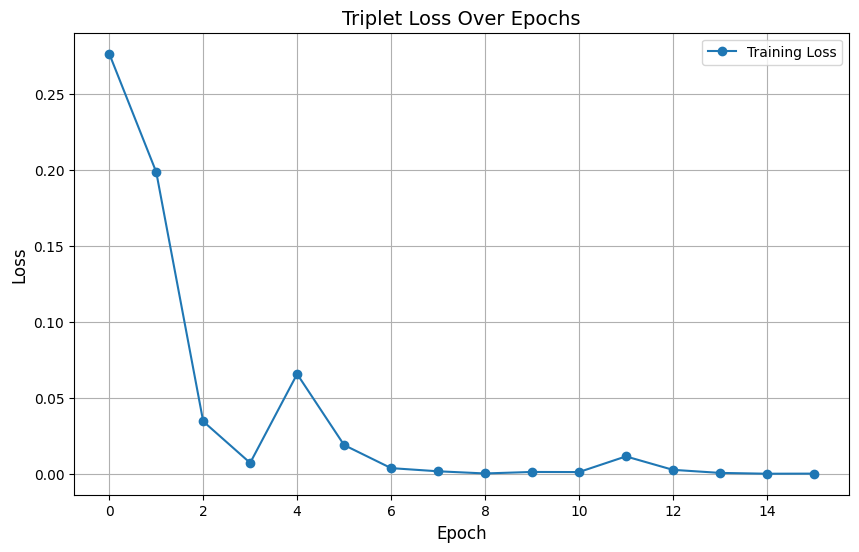

10/10 [==============================] - 25s 2s/step - loss: 6.6731e-05
Epoch 17/100
10/10 [==============================] - ETA: 0s - loss: 0.0011

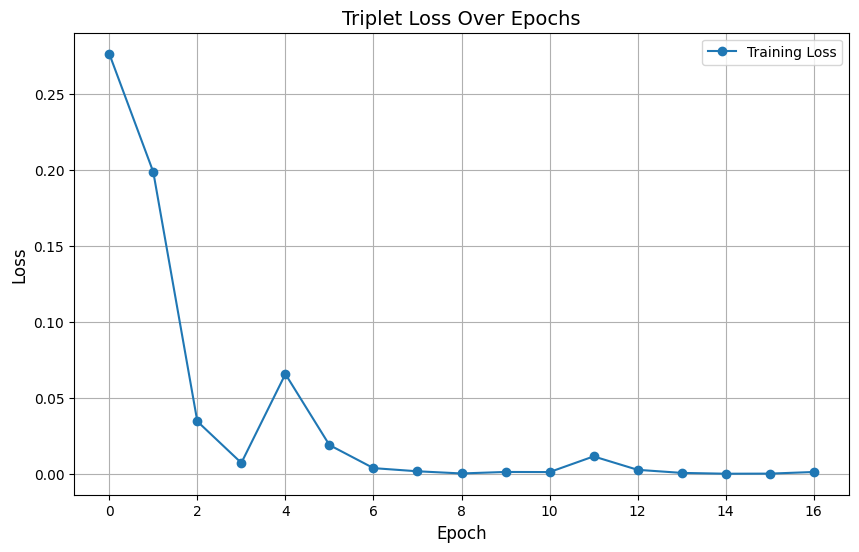

10/10 [==============================] - 25s 3s/step - loss: 0.0011
Epoch 18/100
10/10 [==============================] - ETA: 0s - loss: 9.9480e-04

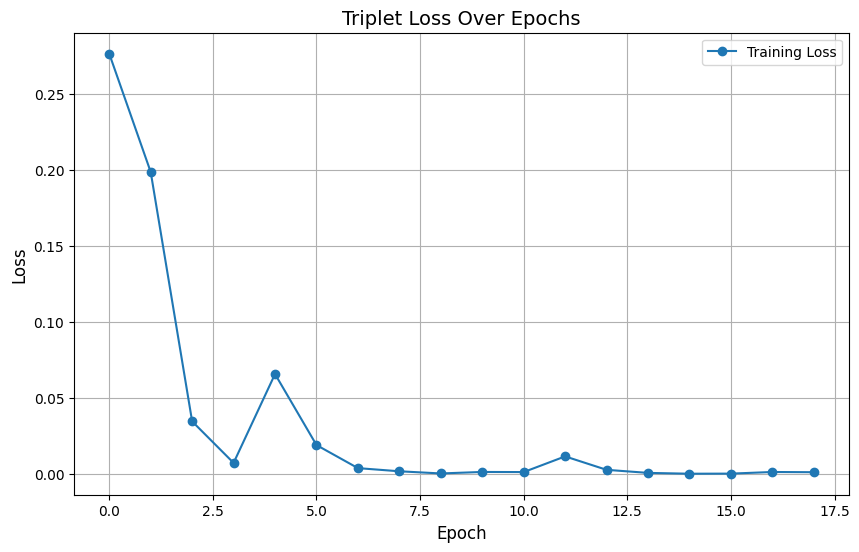

10/10 [==============================] - 26s 3s/step - loss: 9.9480e-04
Epoch 19/100
10/10 [==============================] - ETA: 0s - loss: 0.0133

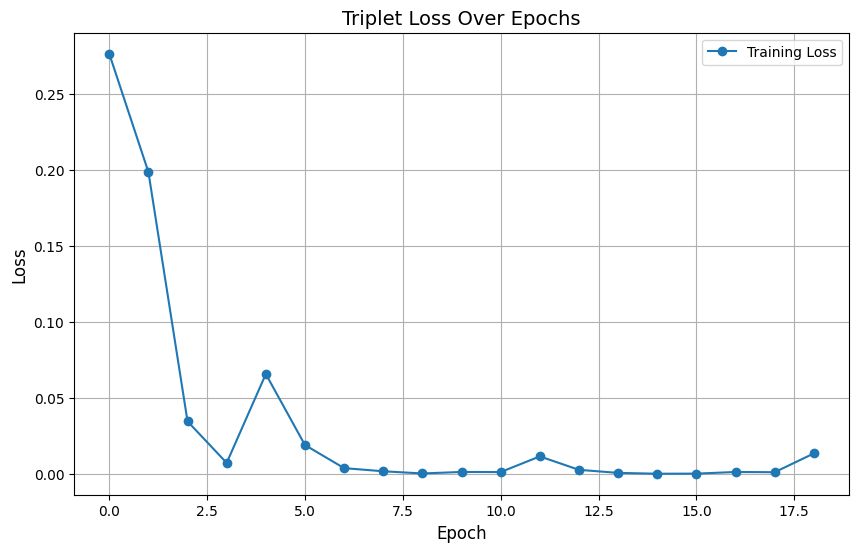

10/10 [==============================] - 27s 3s/step - loss: 0.0133
Epoch 20/100
10/10 [==============================] - ETA: 0s - loss: 0.1653

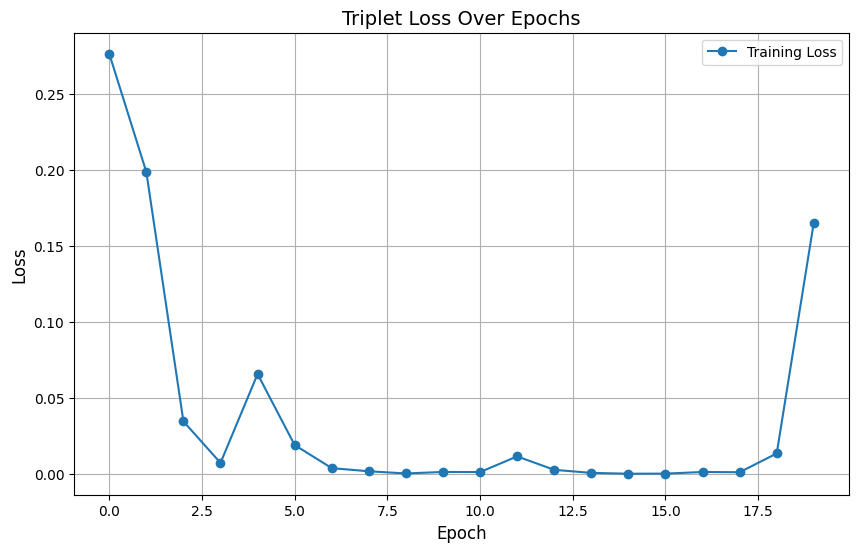

10/10 [==============================] - 25s 3s/step - loss: 0.1653
Epoch 21/100
10/10 [==============================] - ETA: 0s - loss: 0.0242

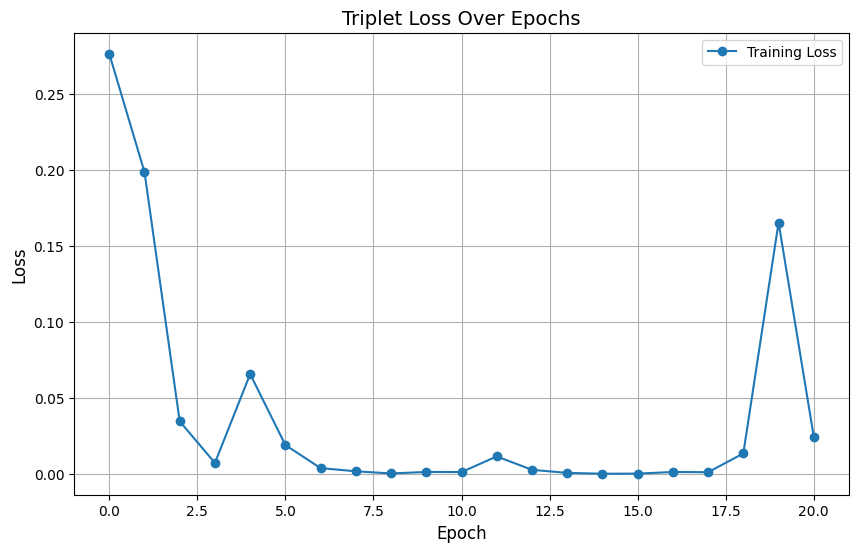

10/10 [==============================] - 24s 2s/step - loss: 0.0242
Epoch 22/100
10/10 [==============================] - ETA: 0s - loss: 0.0047

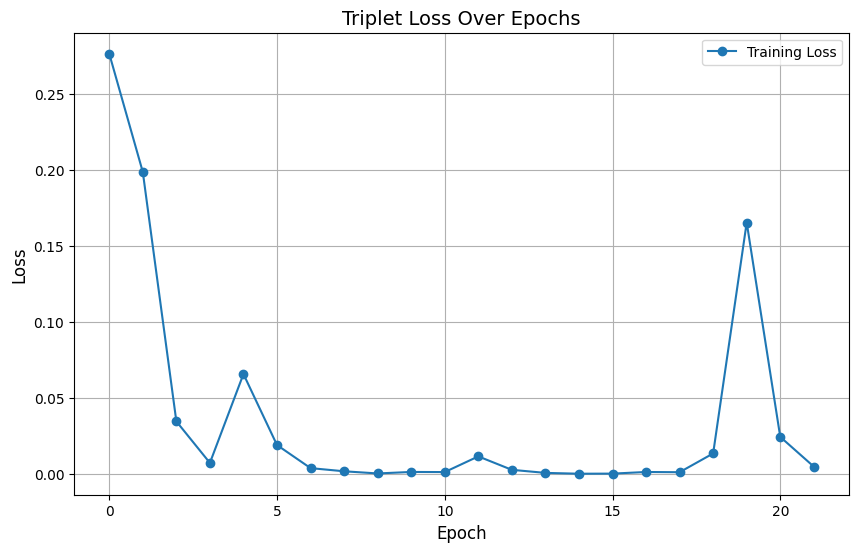

10/10 [==============================] - 25s 3s/step - loss: 0.0047
Epoch 23/100
10/10 [==============================] - ETA: 0s - loss: 0.0019

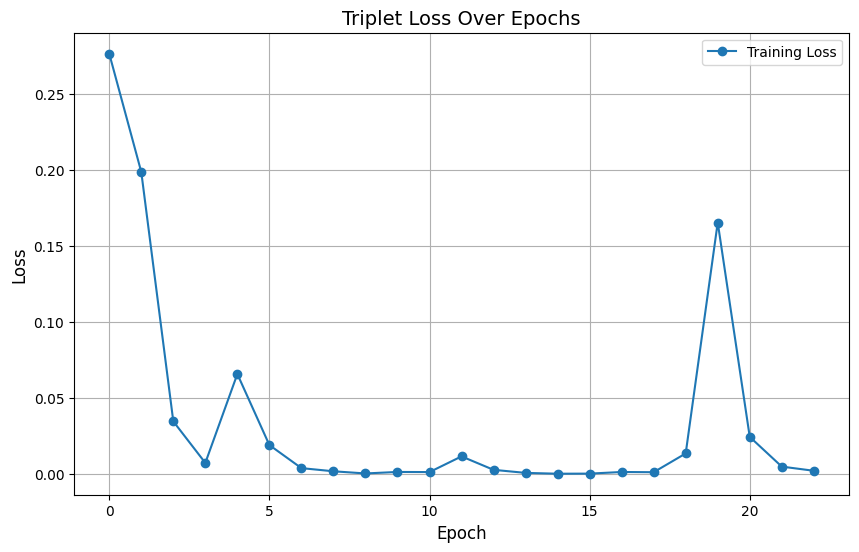

10/10 [==============================] - 24s 2s/step - loss: 0.0019
Epoch 24/100
10/10 [==============================] - ETA: 0s - loss: 5.6651e-04

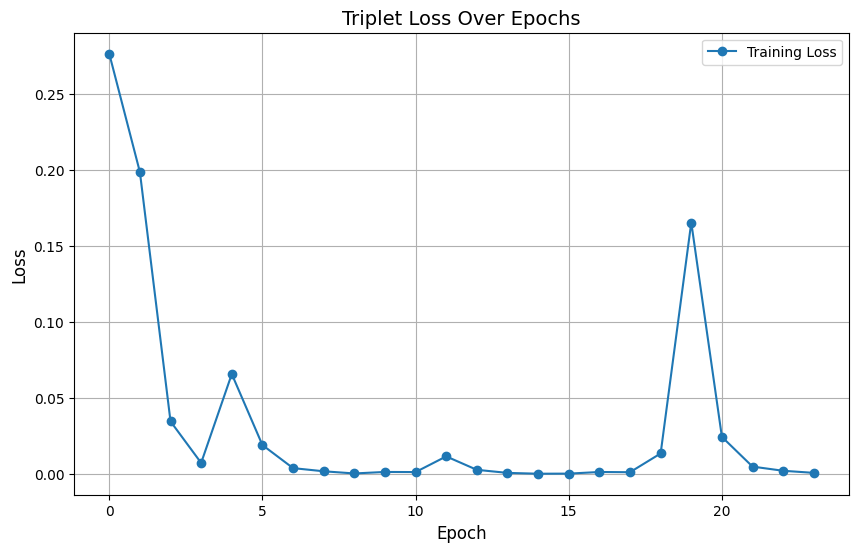

10/10 [==============================] - 25s 2s/step - loss: 5.6651e-04
Epoch 25/100
10/10 [==============================] - ETA: 0s - loss: 0.0032

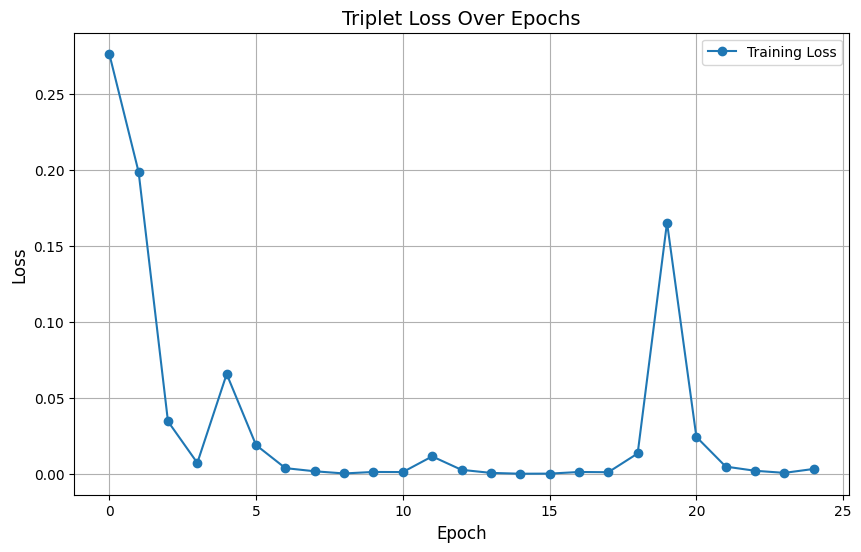

10/10 [==============================] - 25s 3s/step - loss: 0.0032
Epoch 26/100
10/10 [==============================] - ETA: 0s - loss: 0.1839

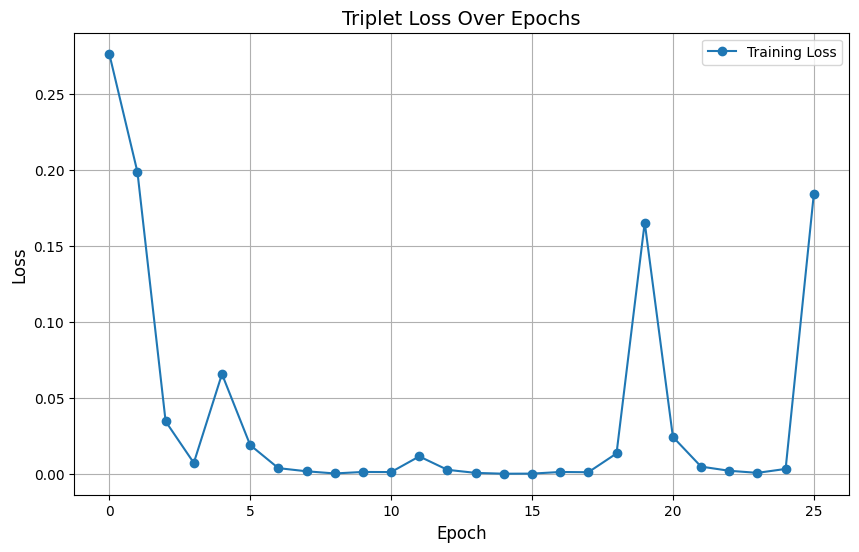

10/10 [==============================] - 25s 3s/step - loss: 0.1839
Epoch 27/100
10/10 [==============================] - ETA: 0s - loss: 0.0083

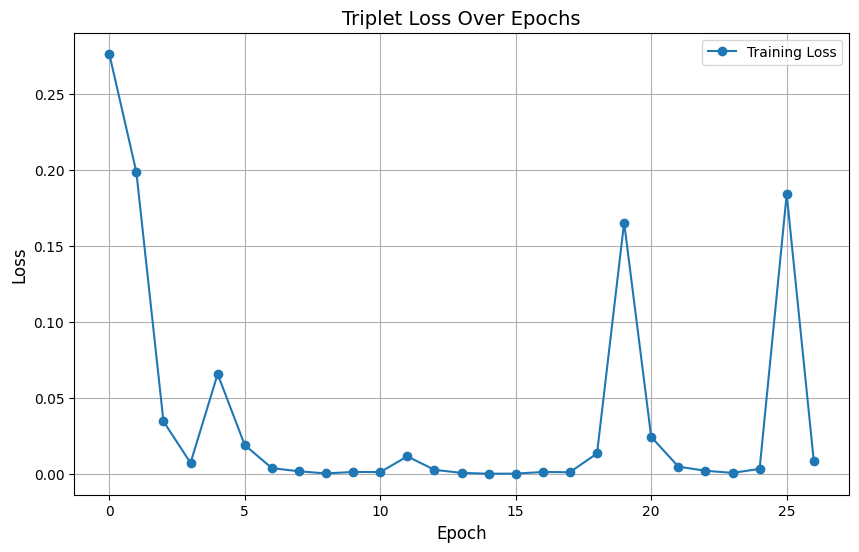

10/10 [==============================] - 26s 3s/step - loss: 0.0083
Epoch 28/100
10/10 [==============================] - ETA: 0s - loss: 0.1468

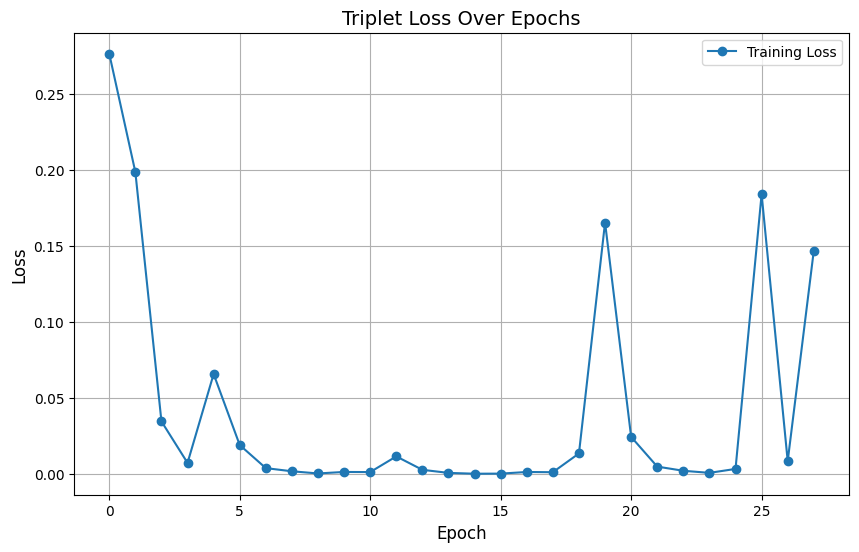

10/10 [==============================] - 24s 2s/step - loss: 0.1468
Epoch 29/100
10/10 [==============================] - ETA: 0s - loss: 0.3556

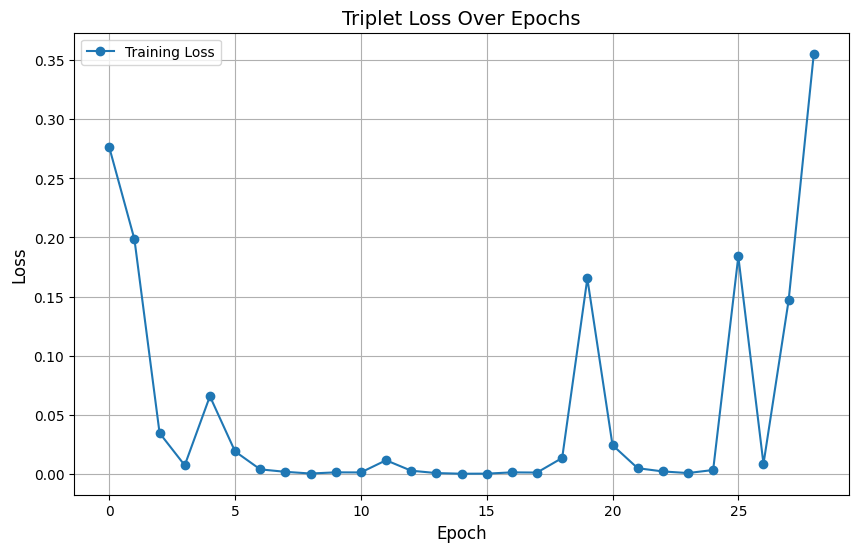

10/10 [==============================] - 25s 3s/step - loss: 0.3556
Epoch 30/100
10/10 [==============================] - ETA: 0s - loss: 0.0326

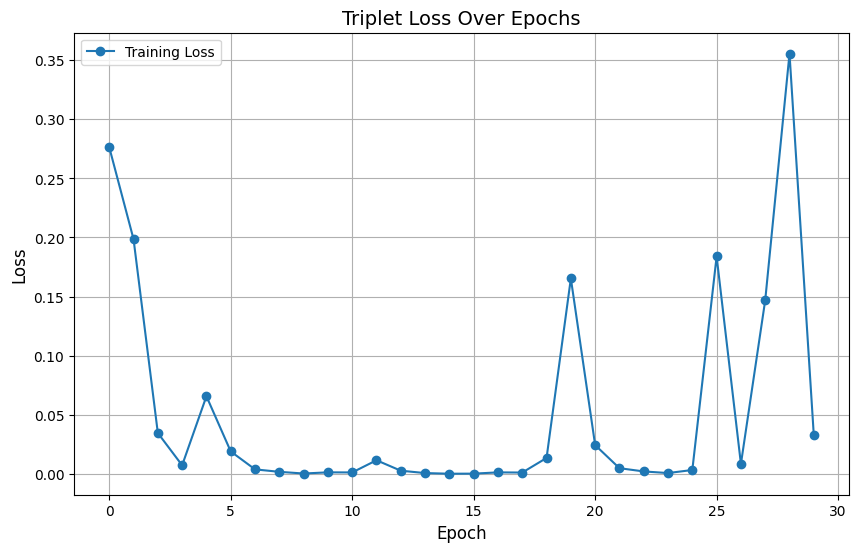

10/10 [==============================] - 24s 2s/step - loss: 0.0326
Epoch 31/100
10/10 [==============================] - ETA: 0s - loss: 0.0096

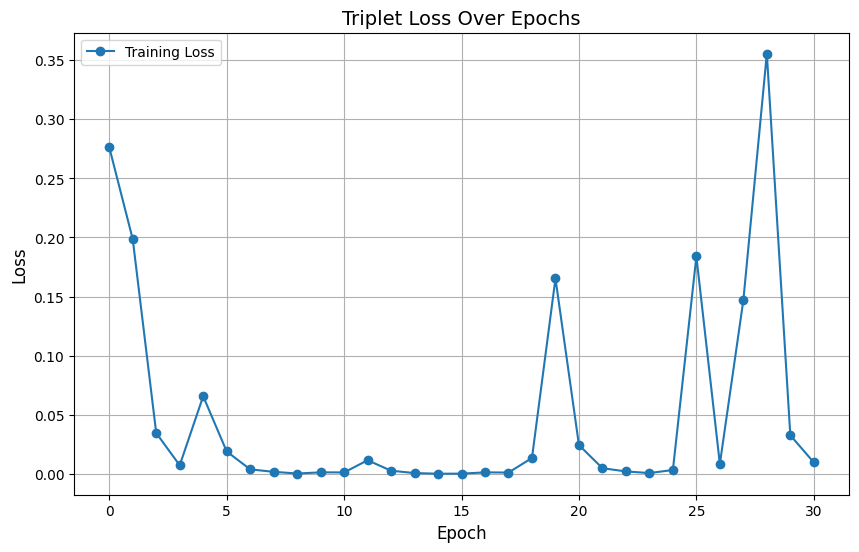

10/10 [==============================] - 25s 2s/step - loss: 0.0096
Epoch 32/100
10/10 [==============================] - ETA: 0s - loss: 3.2052e-04

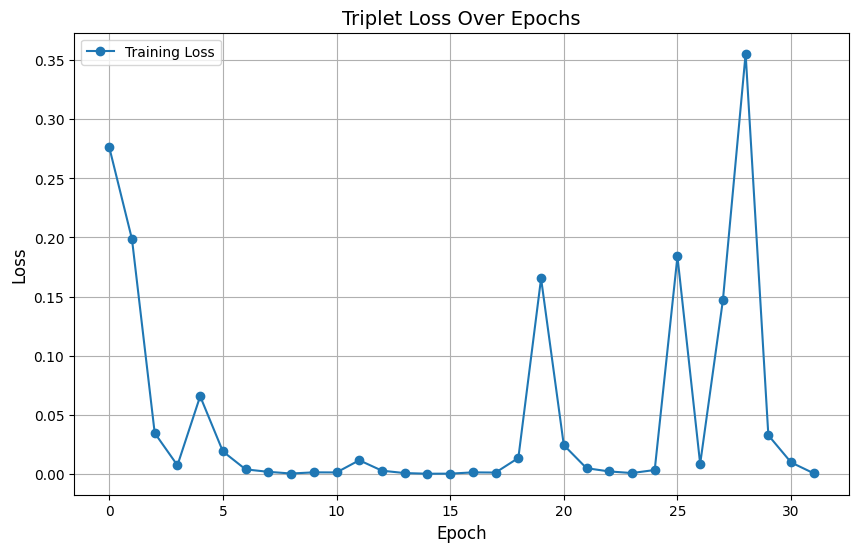

10/10 [==============================] - 25s 3s/step - loss: 3.2052e-04
Epoch 33/100
10/10 [==============================] - ETA: 0s - loss: 1.4476e-04

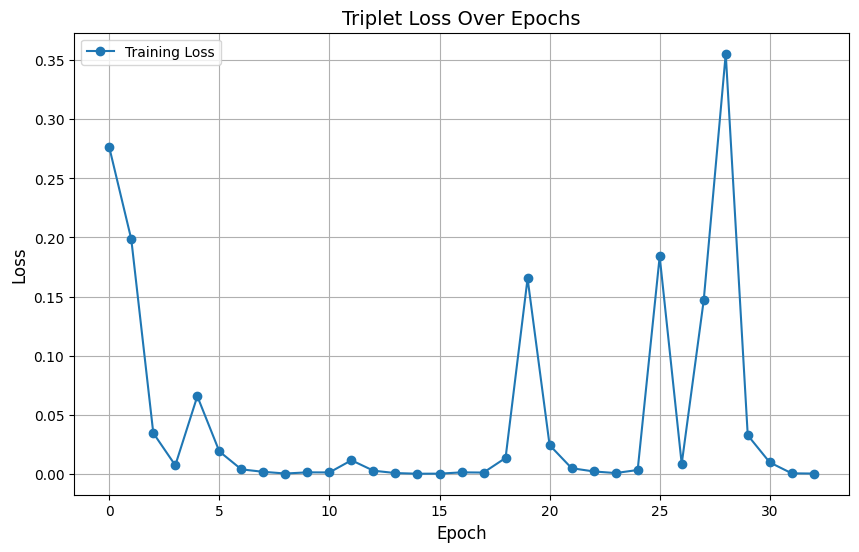

10/10 [==============================] - 25s 3s/step - loss: 1.4476e-04
Epoch 34/100
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00

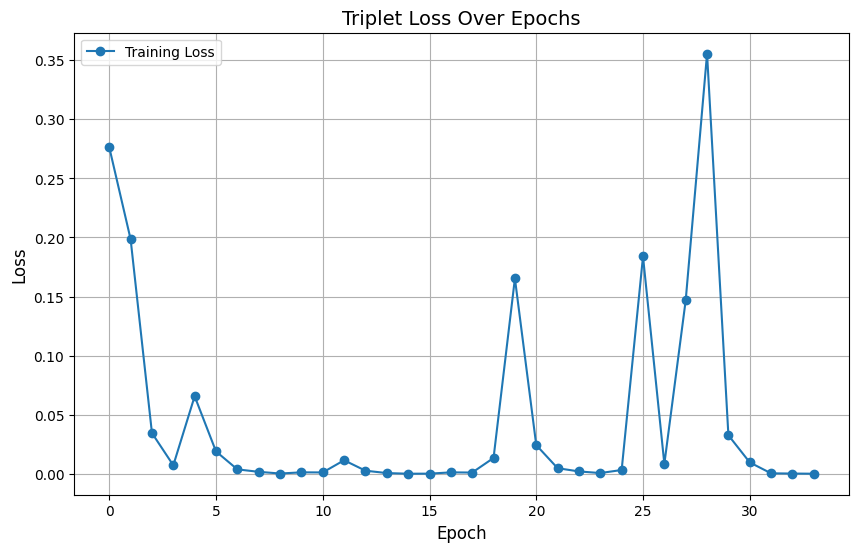

10/10 [==============================] - 24s 2s/step - loss: 0.0000e+00
Epoch 35/100
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00

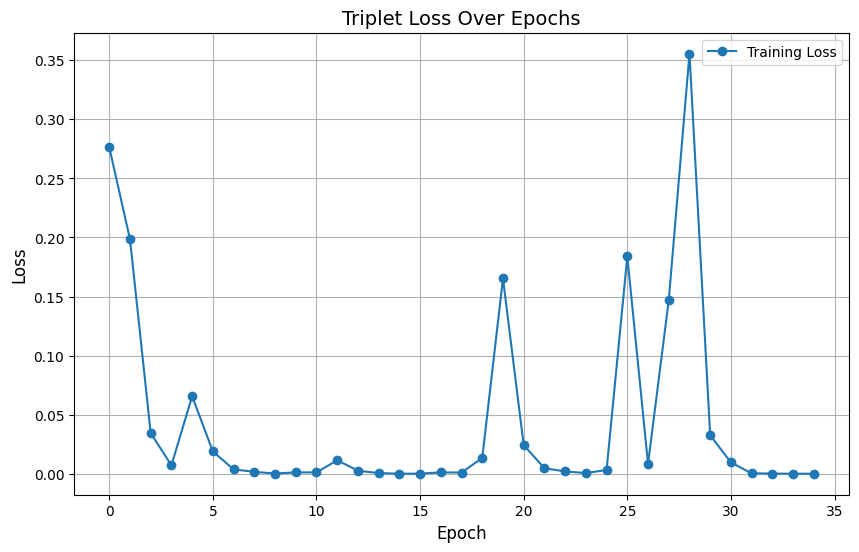

10/10 [==============================] - 25s 3s/step - loss: 0.0000e+00
Epoch 36/100
10/10 [==============================] - ETA: 0s - loss: 2.1140e-04

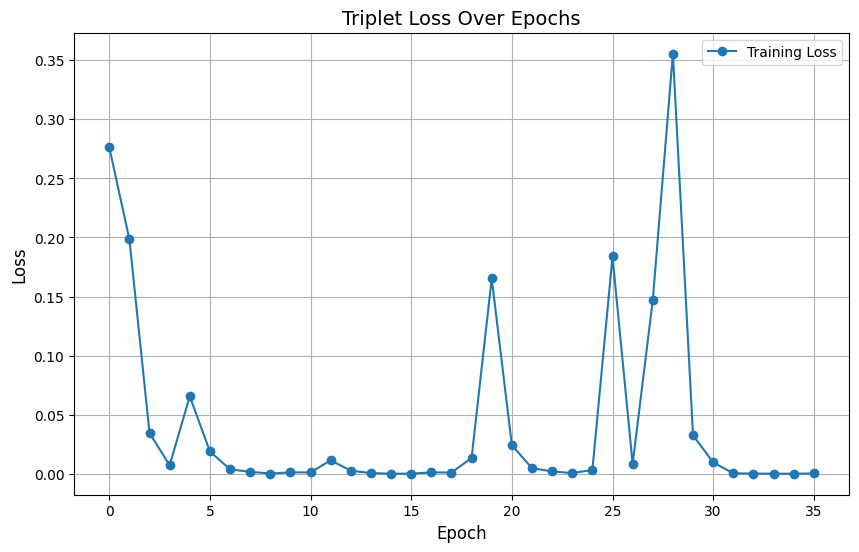

10/10 [==============================] - 23s 2s/step - loss: 2.1140e-04
Epoch 37/100
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00

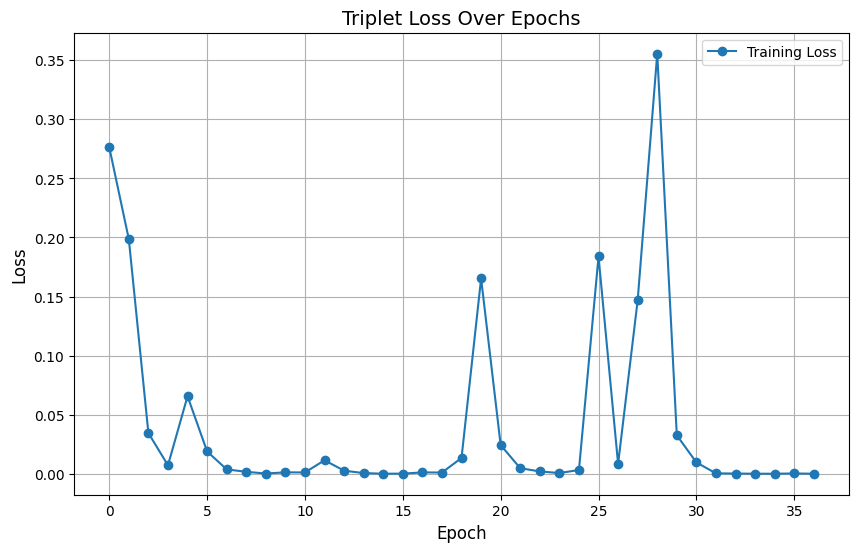

10/10 [==============================] - 25s 2s/step - loss: 0.0000e+00
Epoch 38/100
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00

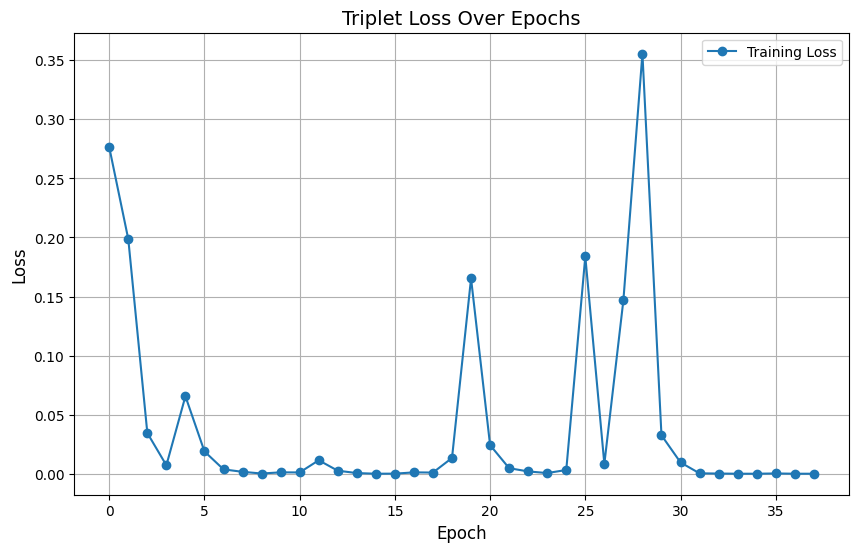

10/10 [==============================] - 26s 3s/step - loss: 0.0000e+00
Epoch 39/100
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00

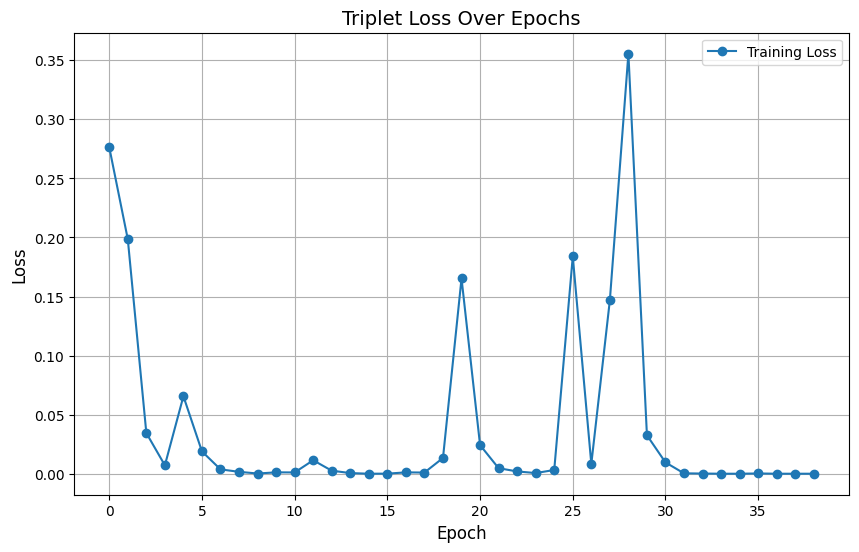

10/10 [==============================] - 26s 3s/step - loss: 0.0000e+00
Epoch 40/100
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00

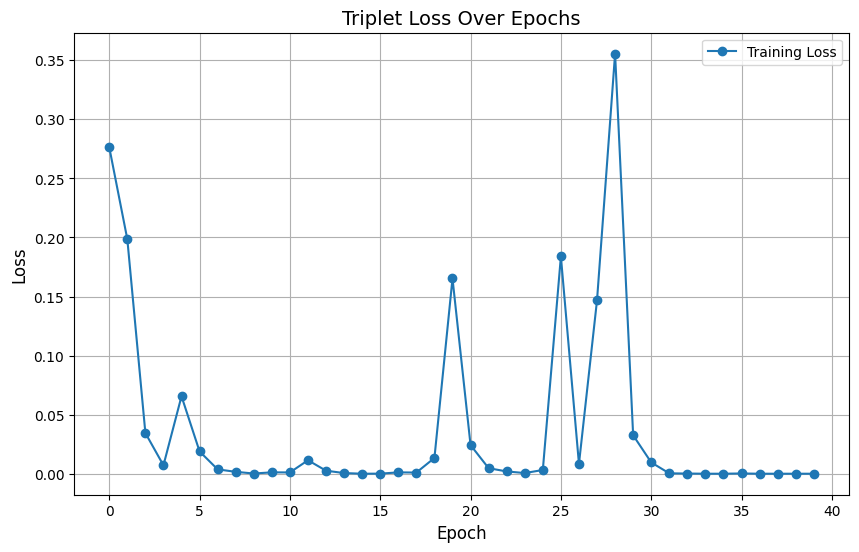

10/10 [==============================] - 26s 3s/step - loss: 0.0000e+00
Epoch 41/100
10/10 [==============================] - ETA: 0s - loss: 7.3527e-05

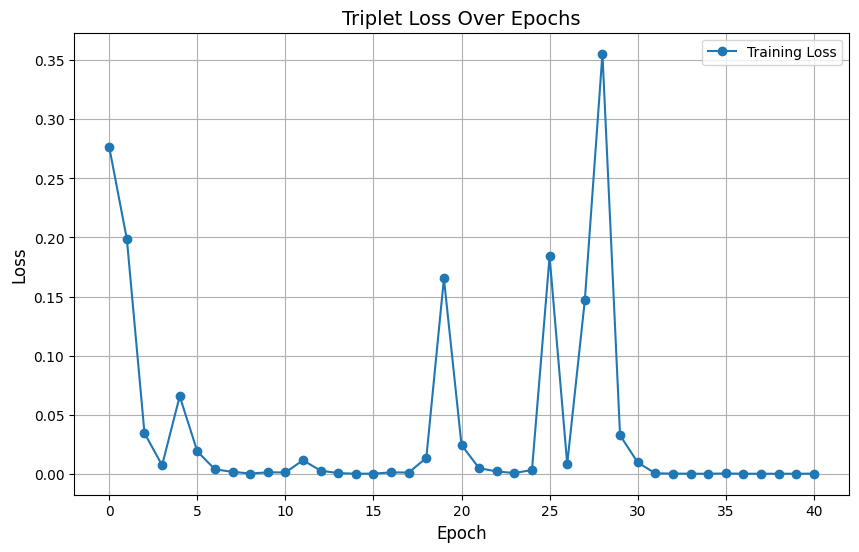

10/10 [==============================] - 25s 3s/step - loss: 7.3527e-05
Epoch 42/100
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00

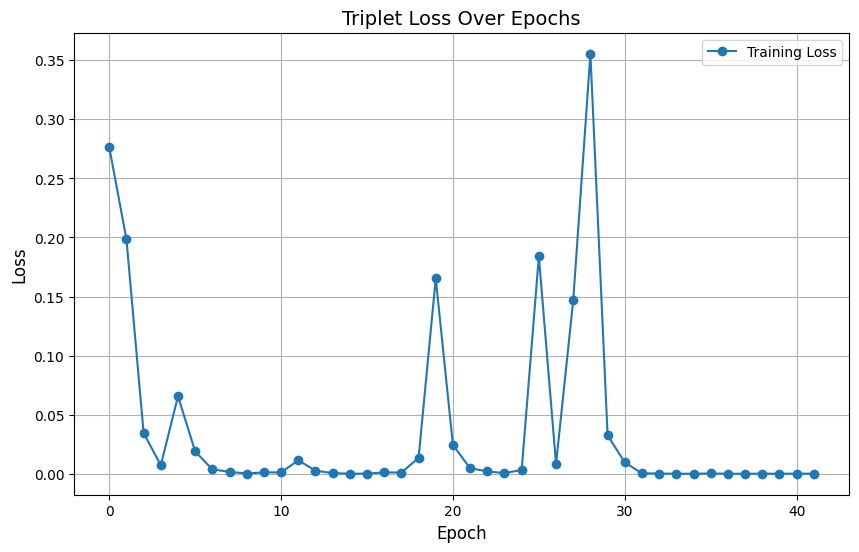

10/10 [==============================] - 25s 2s/step - loss: 0.0000e+00
Epoch 43/100
10/10 [==============================] - ETA: 0s - loss: 2.4059e-04

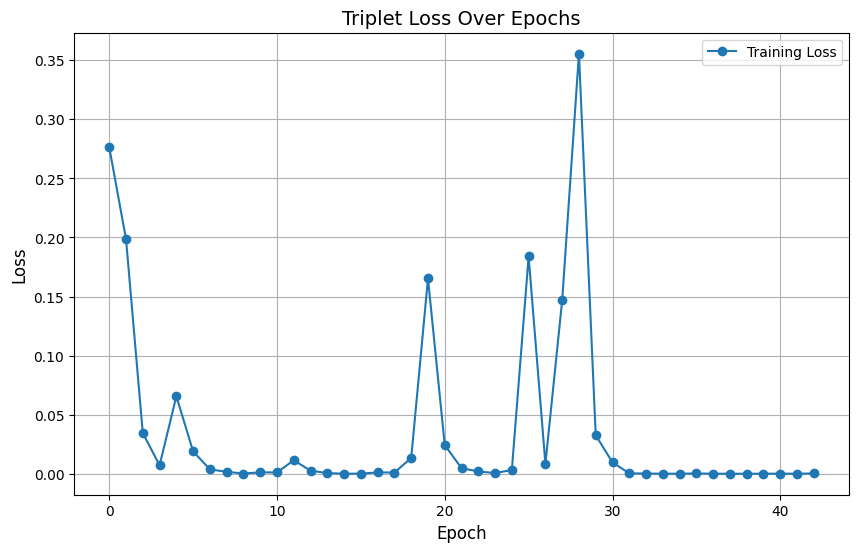

10/10 [==============================] - 24s 2s/step - loss: 2.4059e-04
Epoch 44/100
10/10 [==============================] - ETA: 0s - loss: 6.5258e-05

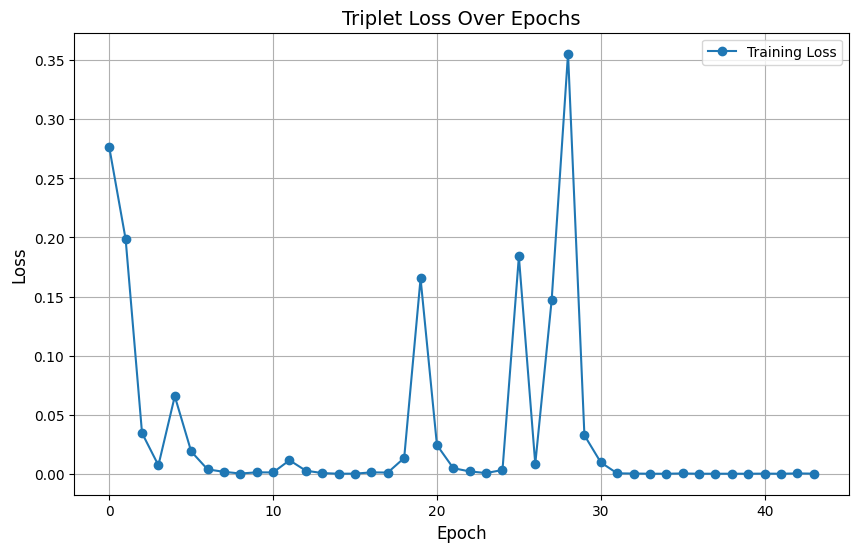

10/10 [==============================] - 25s 3s/step - loss: 6.5258e-05
Epoch 45/100
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00

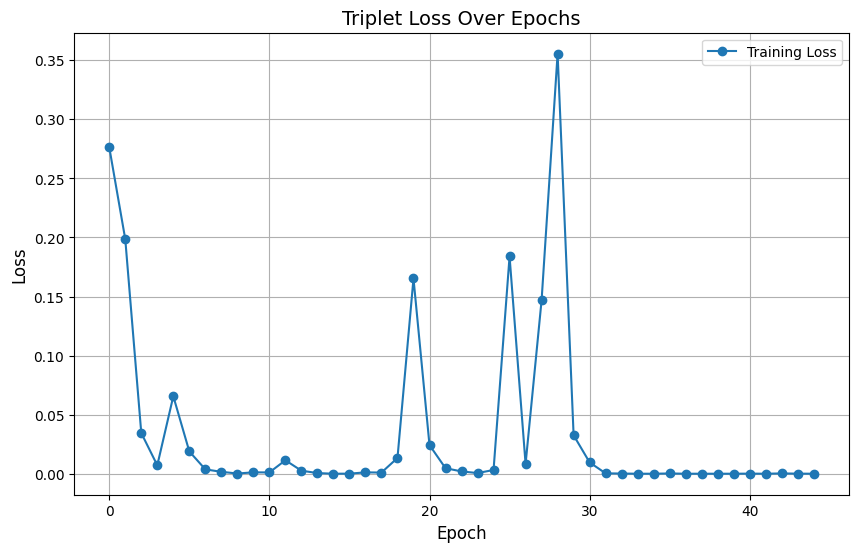

10/10 [==============================] - 24s 2s/step - loss: 0.0000e+00
Epoch 46/100
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00

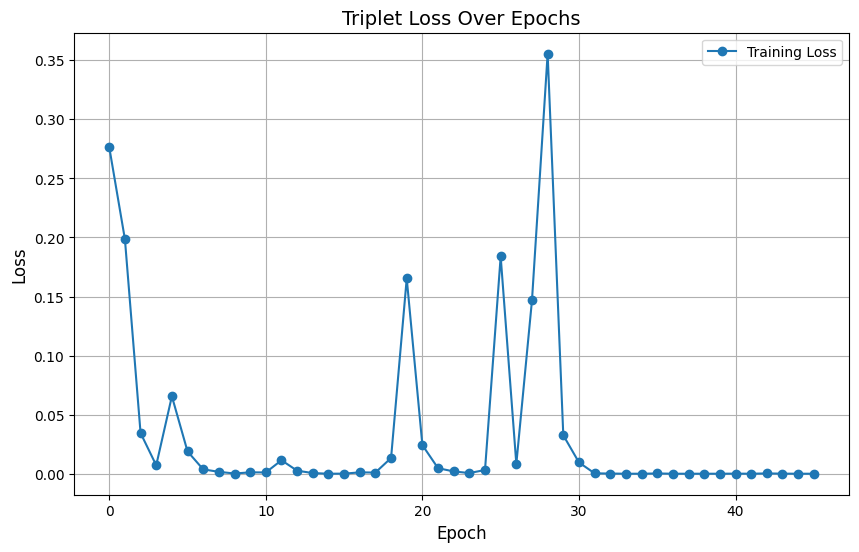

10/10 [==============================] - 24s 2s/step - loss: 0.0000e+00
Epoch 47/100
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00

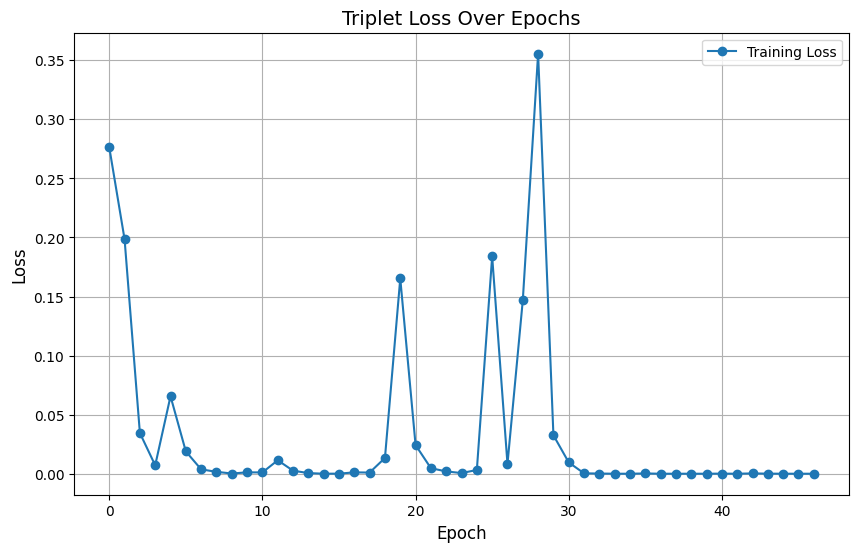

10/10 [==============================] - 26s 3s/step - loss: 0.0000e+00
Epoch 48/100
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00

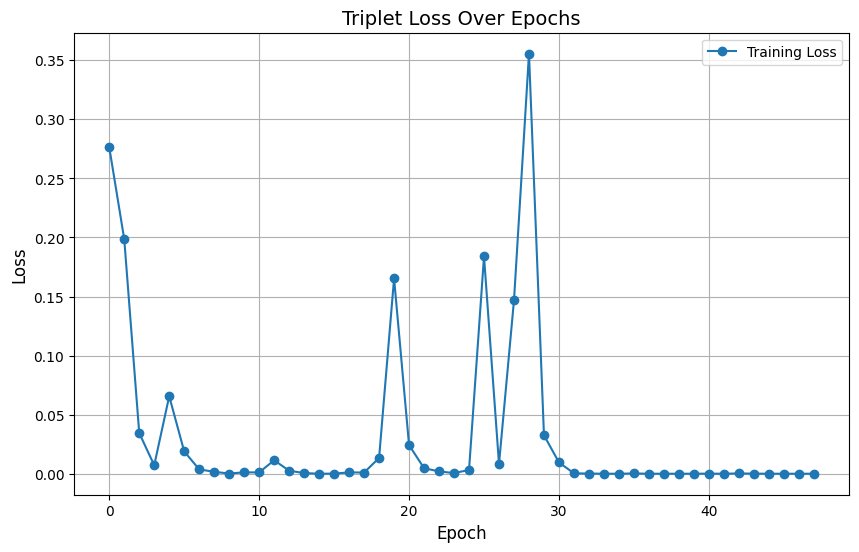

10/10 [==============================] - 24s 2s/step - loss: 0.0000e+00
Epoch 49/100
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00

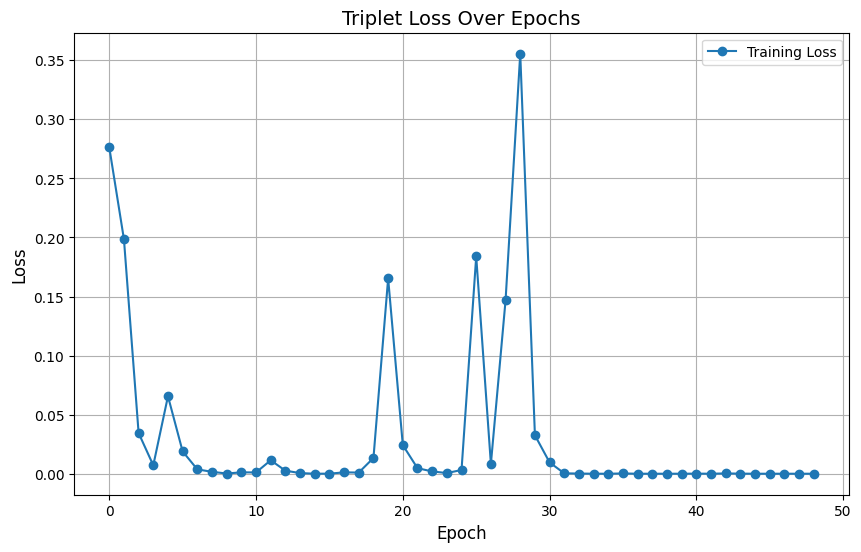

10/10 [==============================] - 26s 3s/step - loss: 0.0000e+00
Epoch 50/100
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00

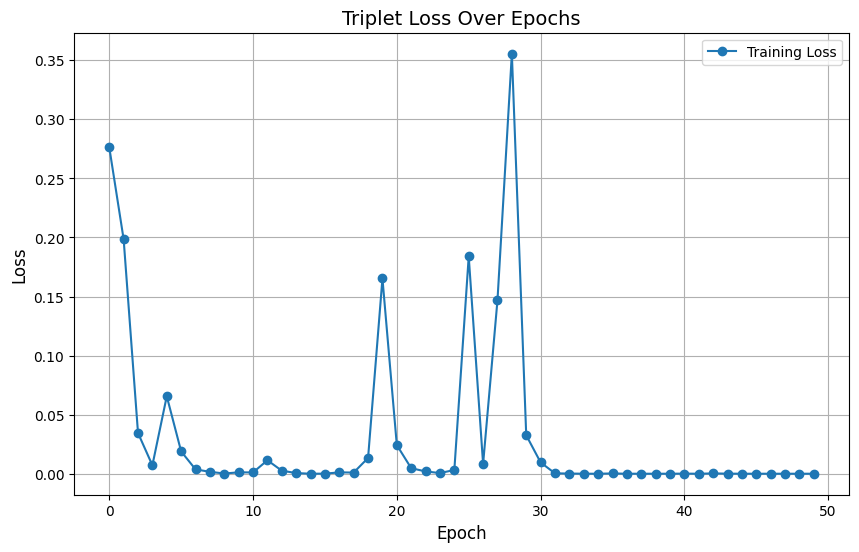

10/10 [==============================] - 25s 3s/step - loss: 0.0000e+00
Epoch 51/100
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00

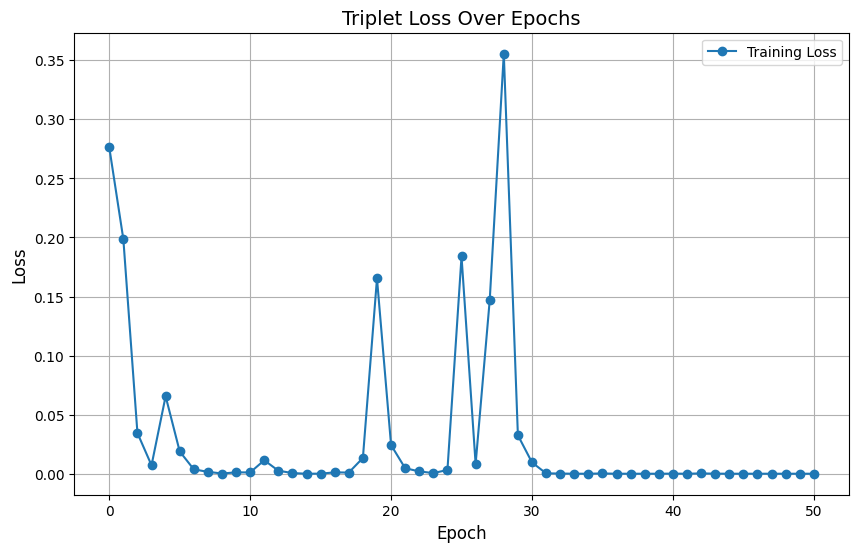

10/10 [==============================] - 26s 2s/step - loss: 0.0000e+00
Epoch 52/100
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00

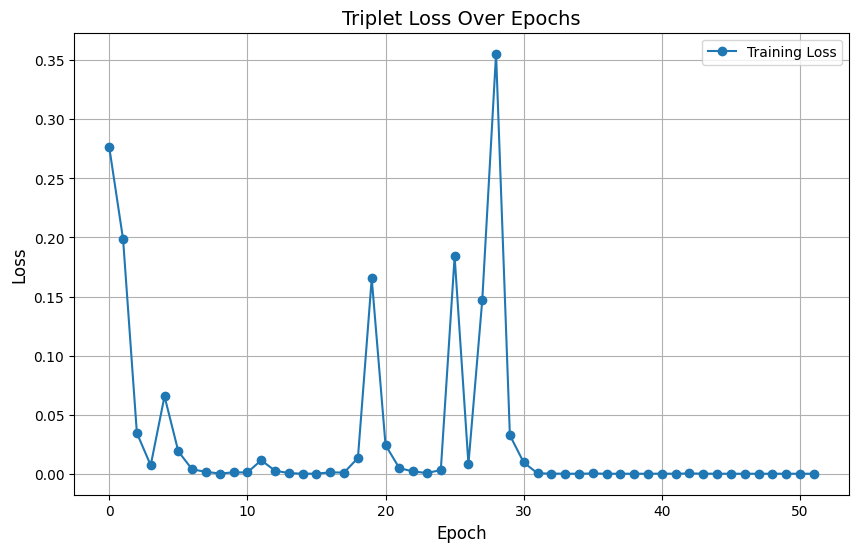

10/10 [==============================] - 25s 2s/step - loss: 0.0000e+00
Epoch 53/100
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00

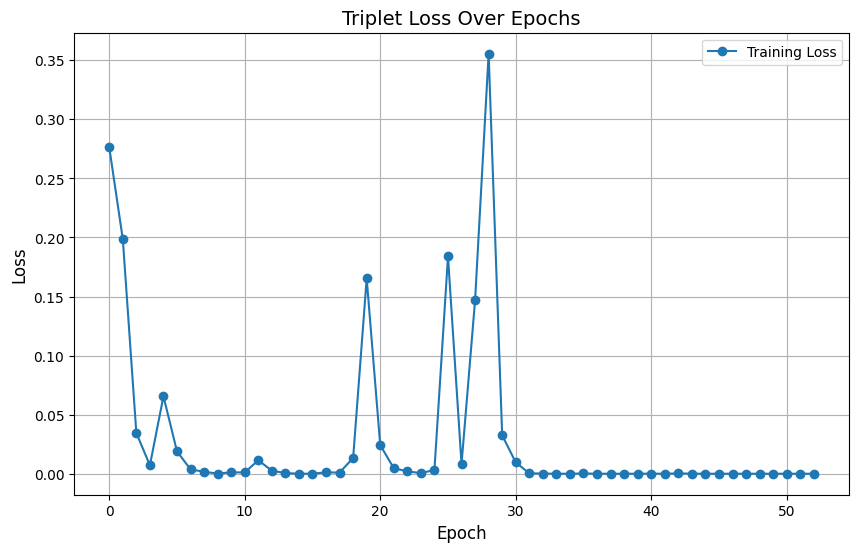

10/10 [==============================] - 25s 2s/step - loss: 0.0000e+00
Epoch 54/100
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00

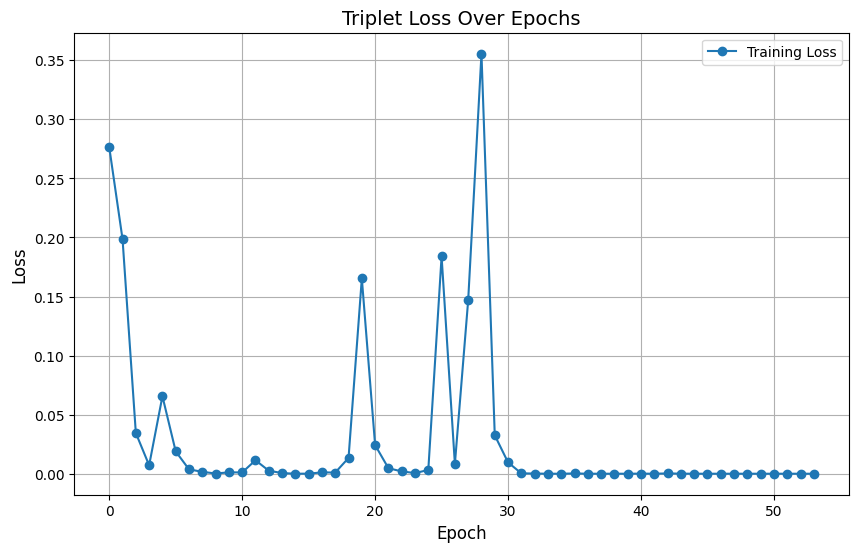

10/10 [==============================] - 26s 3s/step - loss: 0.0000e+00
Epoch 55/100
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00

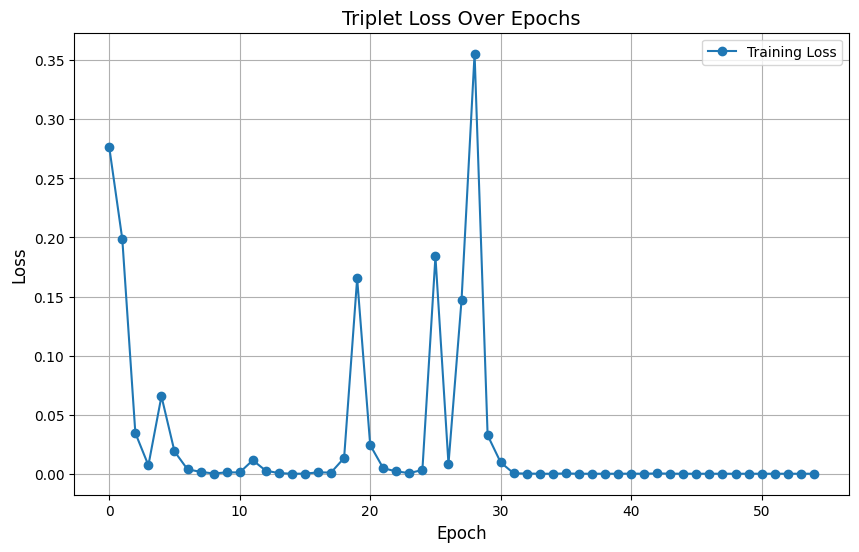

10/10 [==============================] - 26s 3s/step - loss: 0.0000e+00
Epoch 56/100
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00

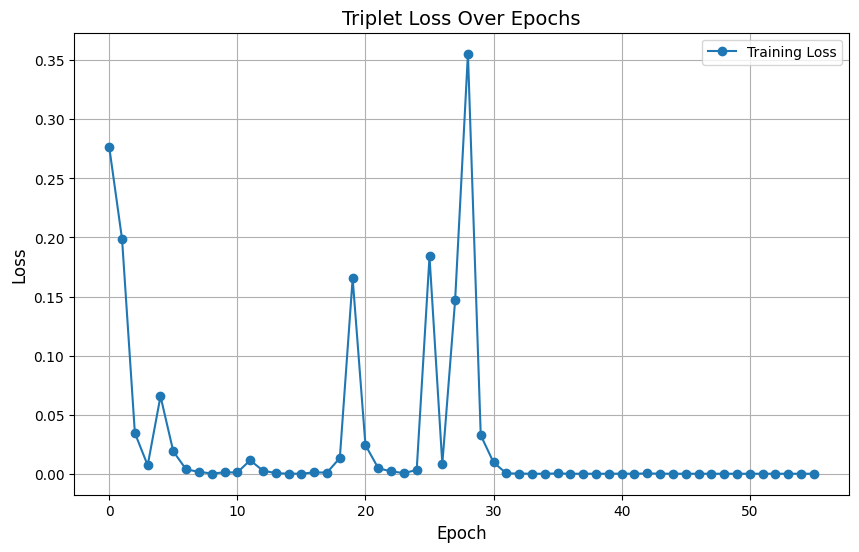

10/10 [==============================] - 26s 3s/step - loss: 0.0000e+00
Epoch 57/100
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00

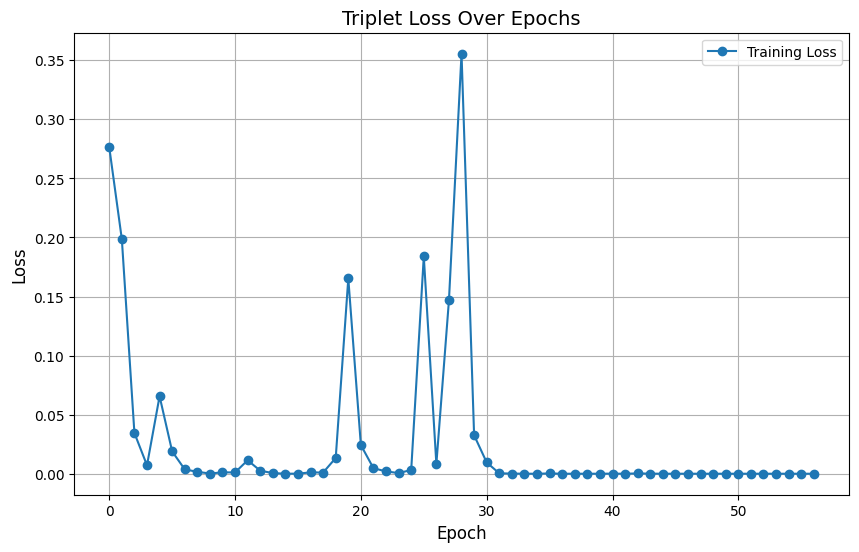

10/10 [==============================] - 25s 3s/step - loss: 0.0000e+00
Epoch 58/100
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00

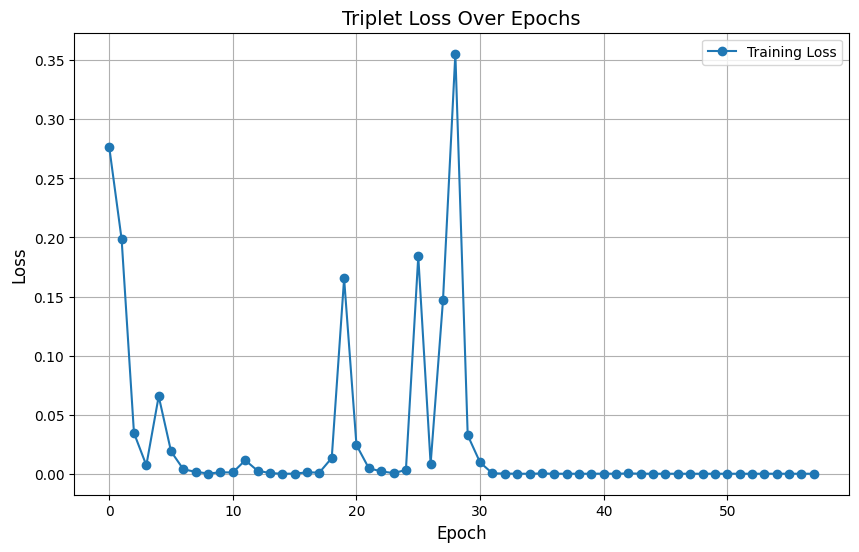

10/10 [==============================] - 26s 3s/step - loss: 0.0000e+00
Epoch 59/100
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00

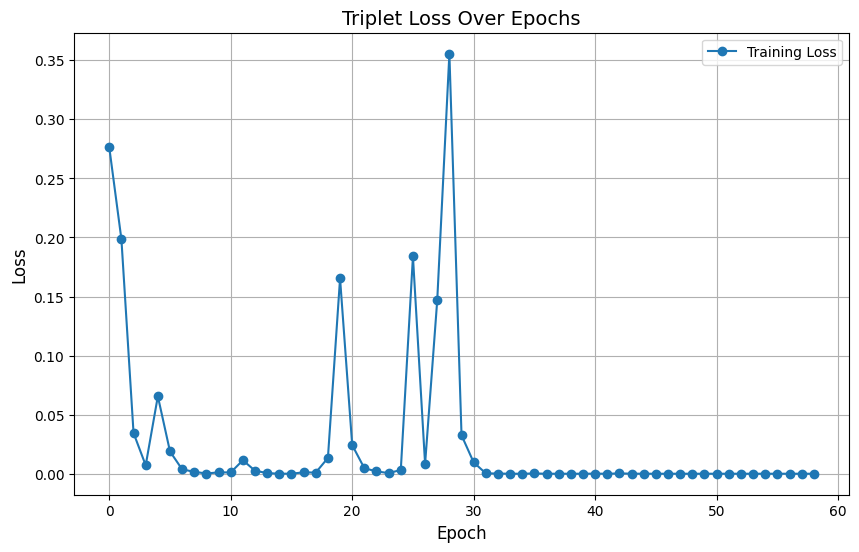

10/10 [==============================] - 24s 2s/step - loss: 0.0000e+00
Epoch 60/100
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00

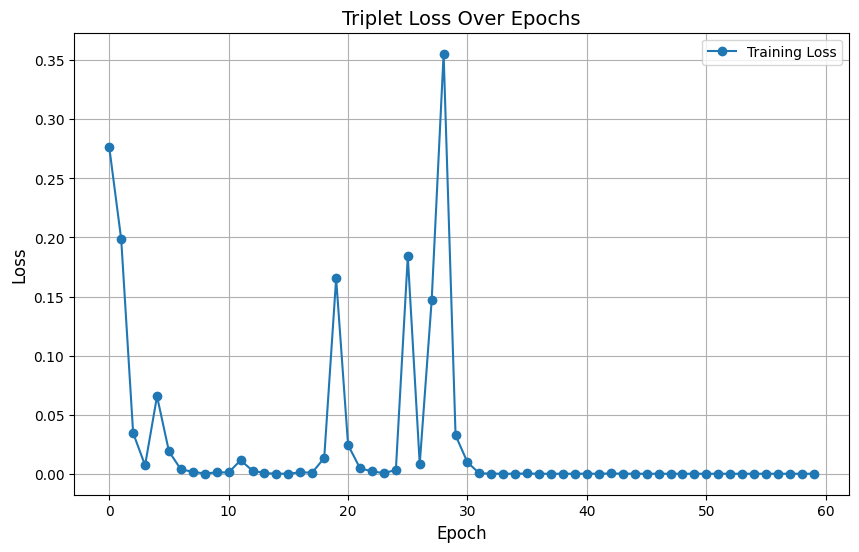

10/10 [==============================] - 24s 2s/step - loss: 0.0000e+00
Epoch 61/100
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00

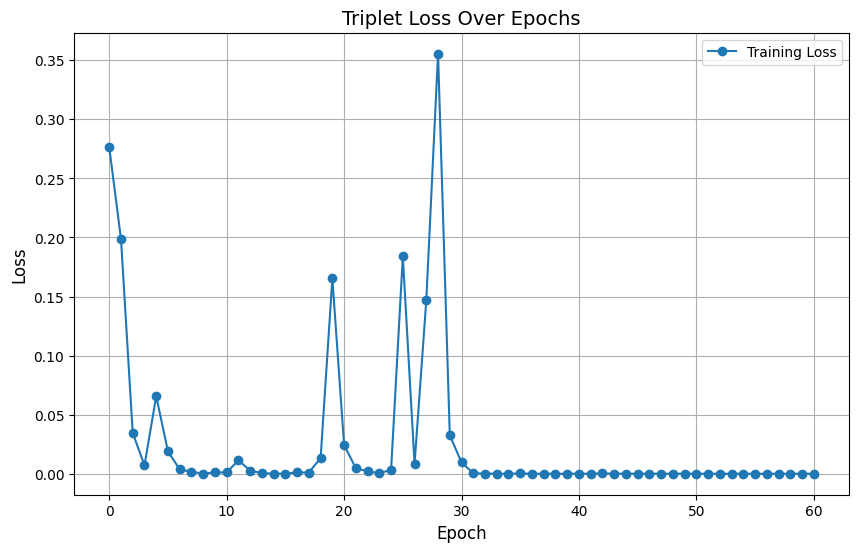

10/10 [==============================] - 24s 2s/step - loss: 0.0000e+00
Epoch 62/100
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00

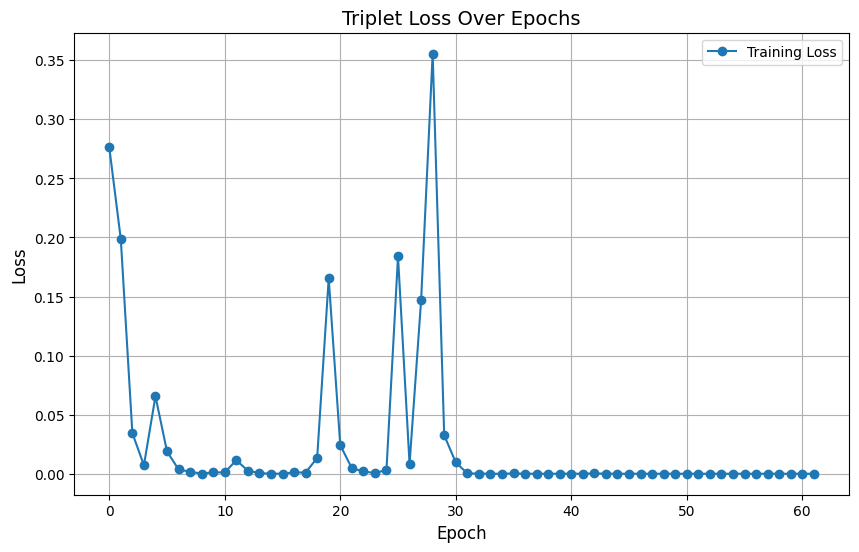

10/10 [==============================] - 25s 3s/step - loss: 0.0000e+00
Epoch 63/100
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00

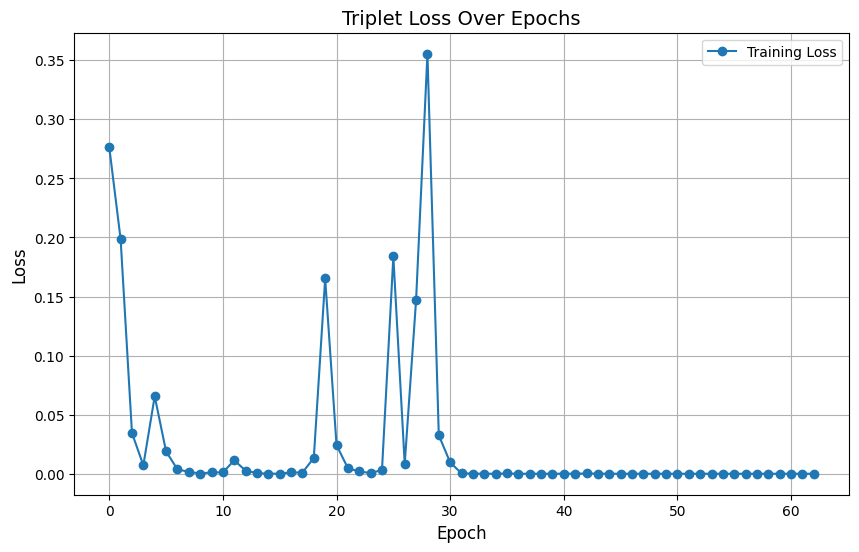

10/10 [==============================] - 26s 3s/step - loss: 0.0000e+00
Epoch 64/100
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00

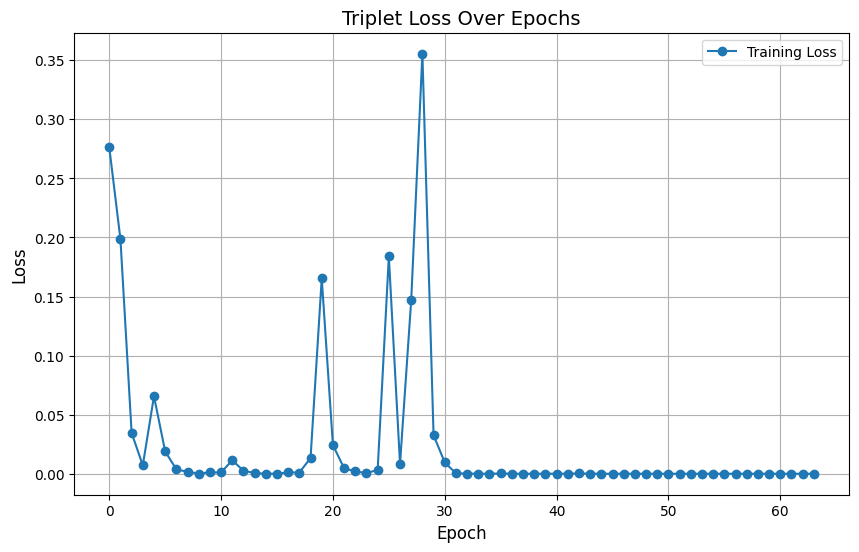

10/10 [==============================] - 25s 3s/step - loss: 0.0000e+00
Epoch 65/100
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00

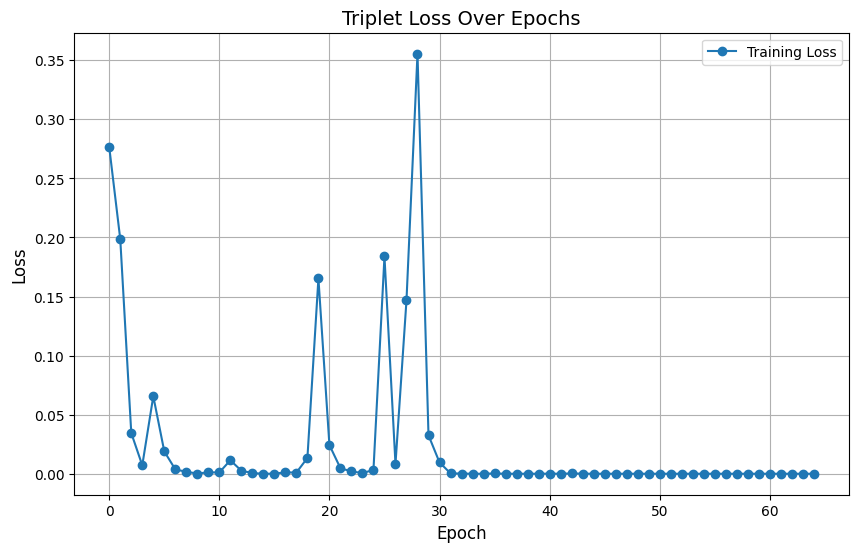

10/10 [==============================] - 27s 3s/step - loss: 0.0000e+00
Epoch 66/100
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00

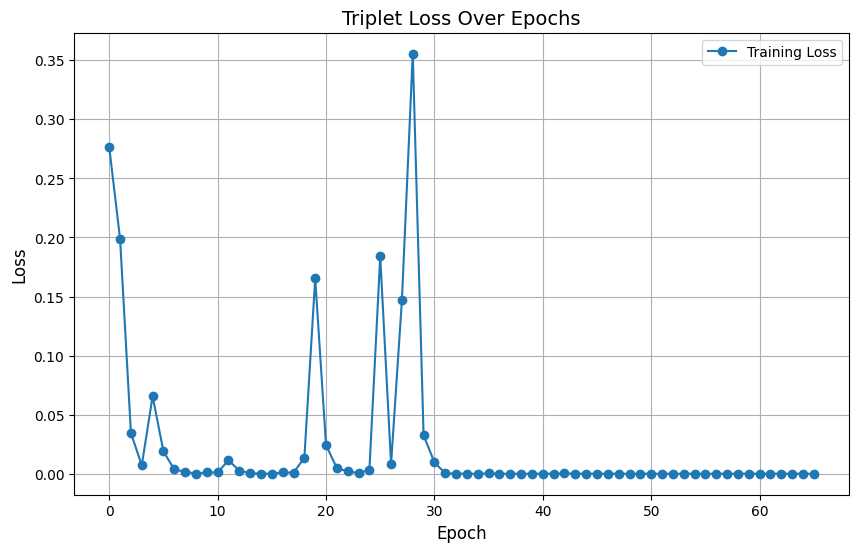

10/10 [==============================] - 26s 3s/step - loss: 0.0000e+00
Epoch 67/100
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00

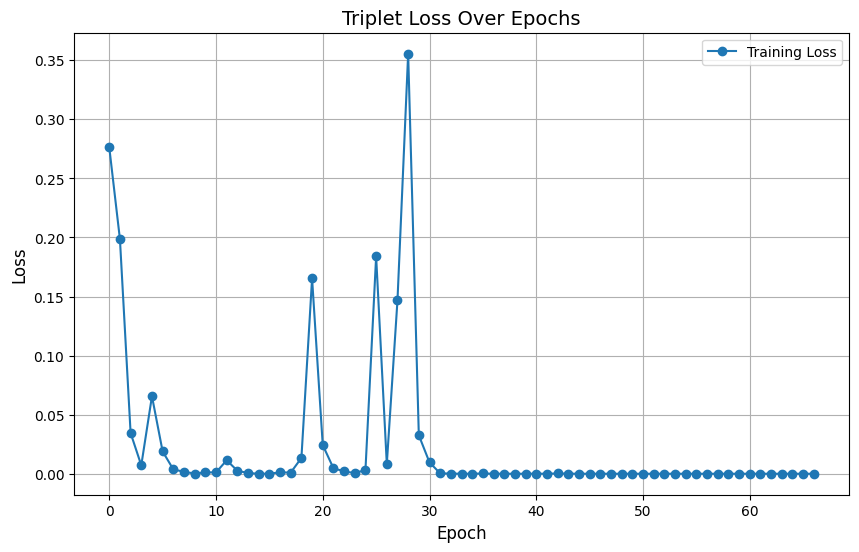

10/10 [==============================] - 26s 3s/step - loss: 0.0000e+00
Epoch 68/100
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00

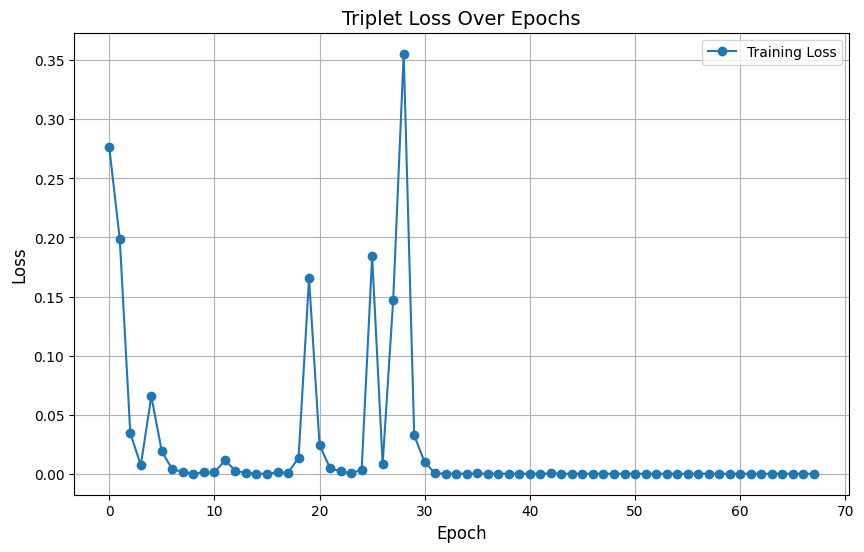

10/10 [==============================] - 25s 2s/step - loss: 0.0000e+00
Epoch 69/100
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00

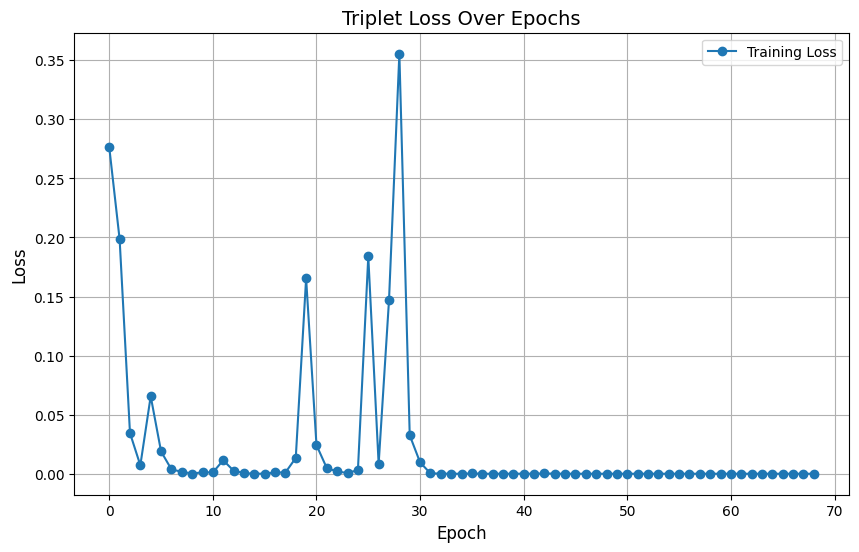

10/10 [==============================] - 26s 2s/step - loss: 0.0000e+00
Epoch 70/100
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00

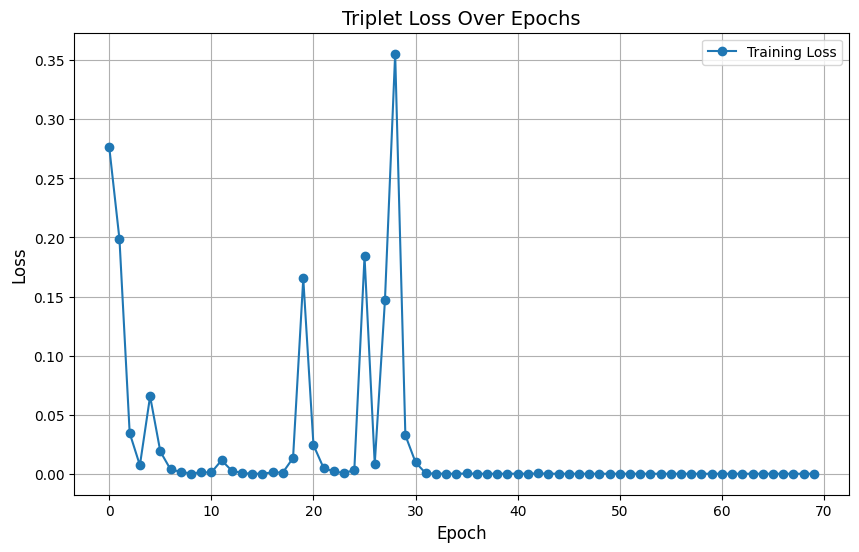

10/10 [==============================] - 26s 3s/step - loss: 0.0000e+00
Epoch 71/100
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00

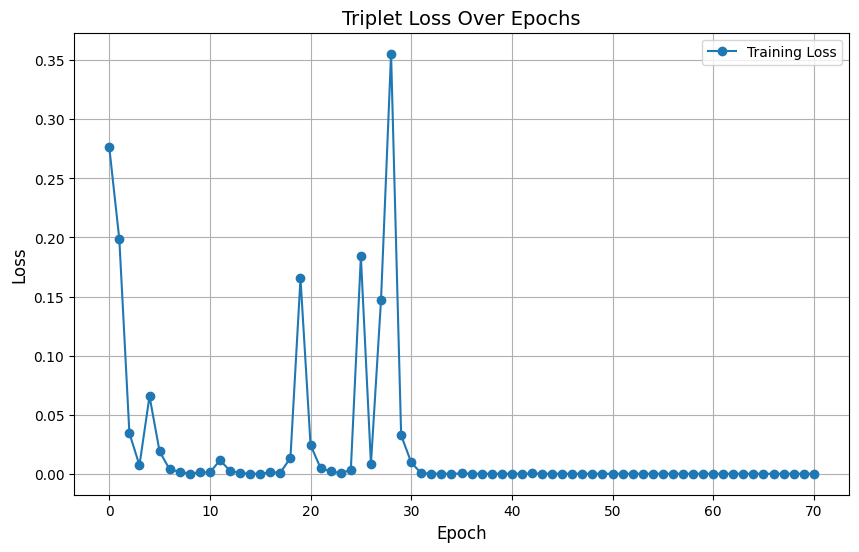

10/10 [==============================] - 26s 3s/step - loss: 0.0000e+00
Epoch 72/100
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00

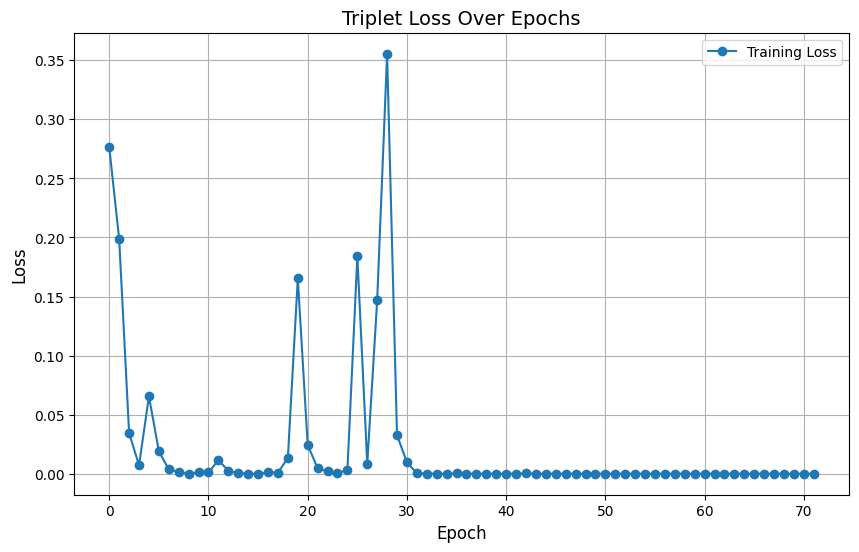

10/10 [==============================] - 25s 3s/step - loss: 0.0000e+00
Epoch 73/100
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00

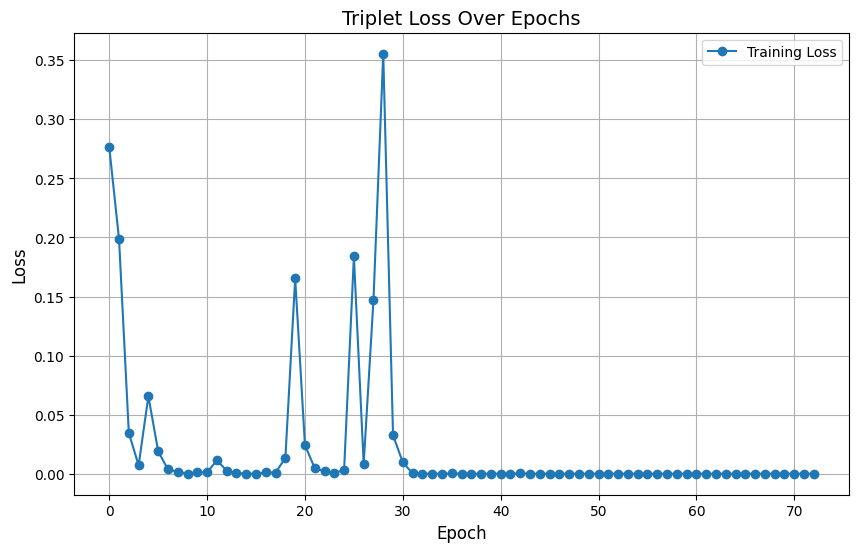

10/10 [==============================] - 25s 3s/step - loss: 0.0000e+00
Epoch 74/100
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00

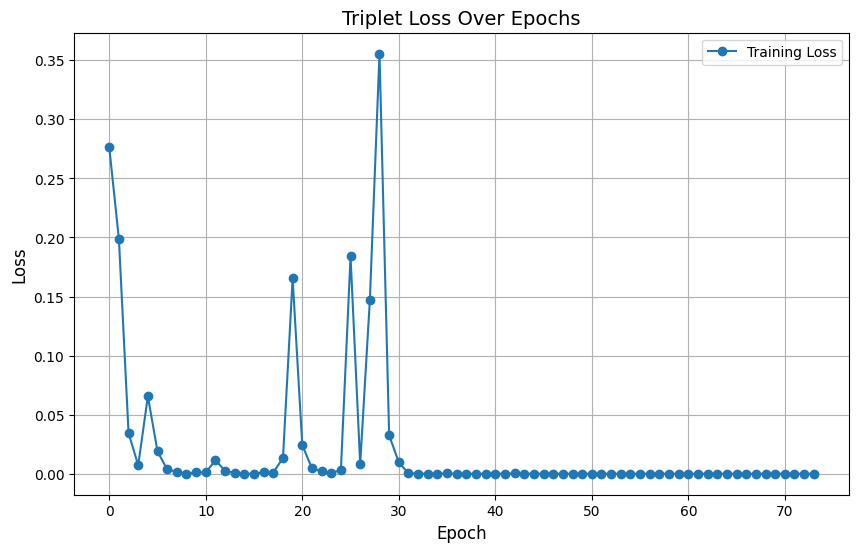

10/10 [==============================] - 25s 3s/step - loss: 0.0000e+00
Epoch 75/100
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00

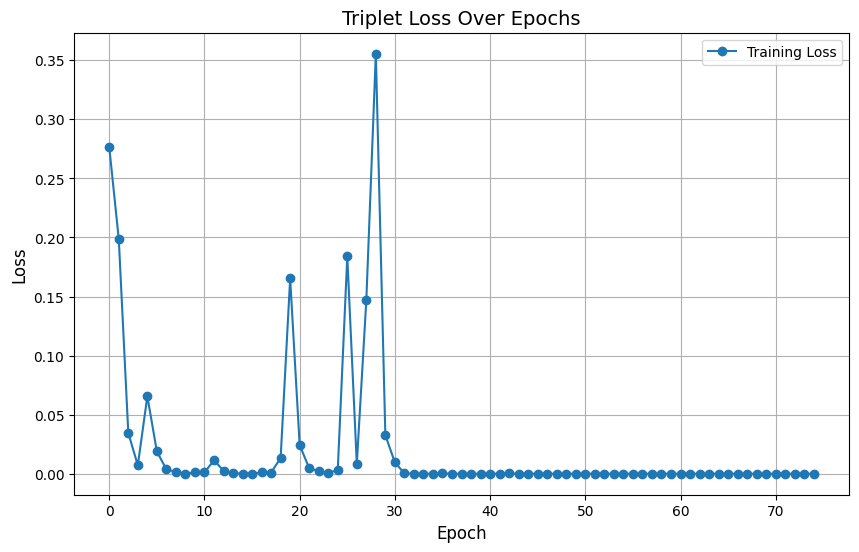

10/10 [==============================] - 25s 3s/step - loss: 0.0000e+00
Epoch 76/100
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00

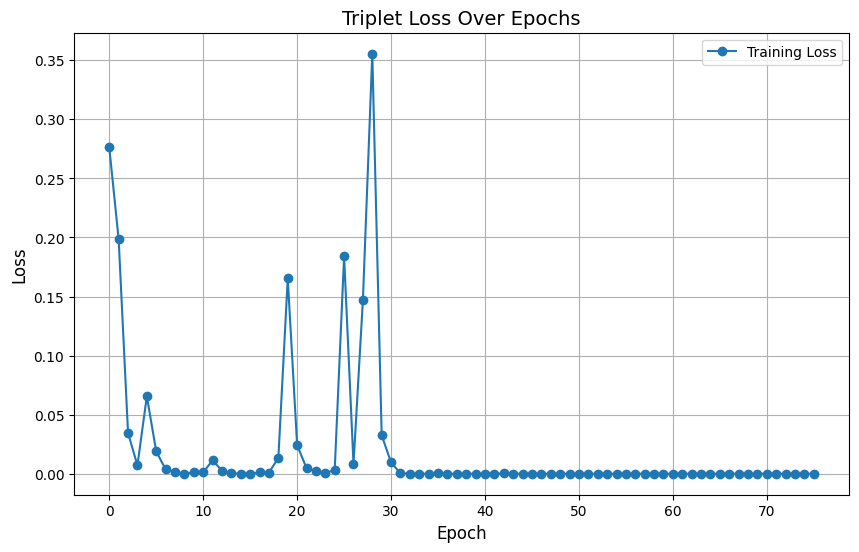

10/10 [==============================] - 26s 3s/step - loss: 0.0000e+00
Epoch 77/100
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00

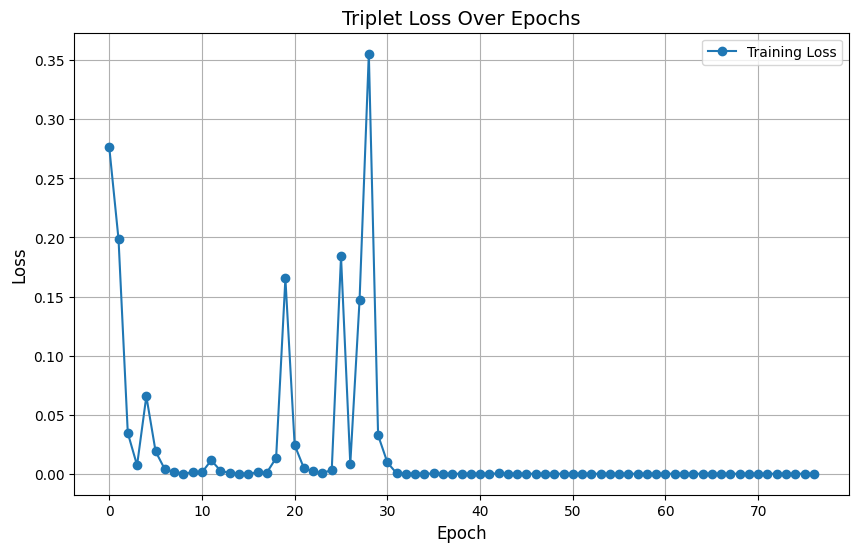

10/10 [==============================] - 25s 3s/step - loss: 0.0000e+00
Epoch 78/100
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00

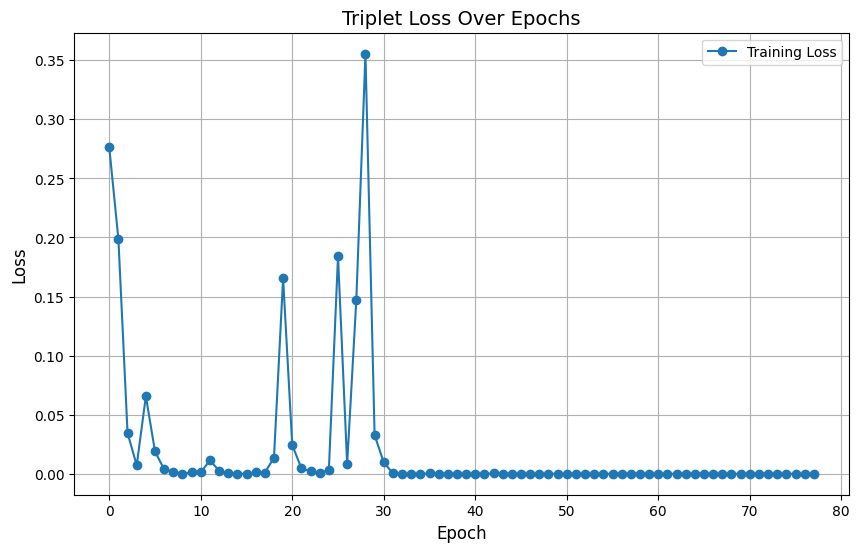

10/10 [==============================] - 25s 3s/step - loss: 0.0000e+00
Epoch 79/100
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00

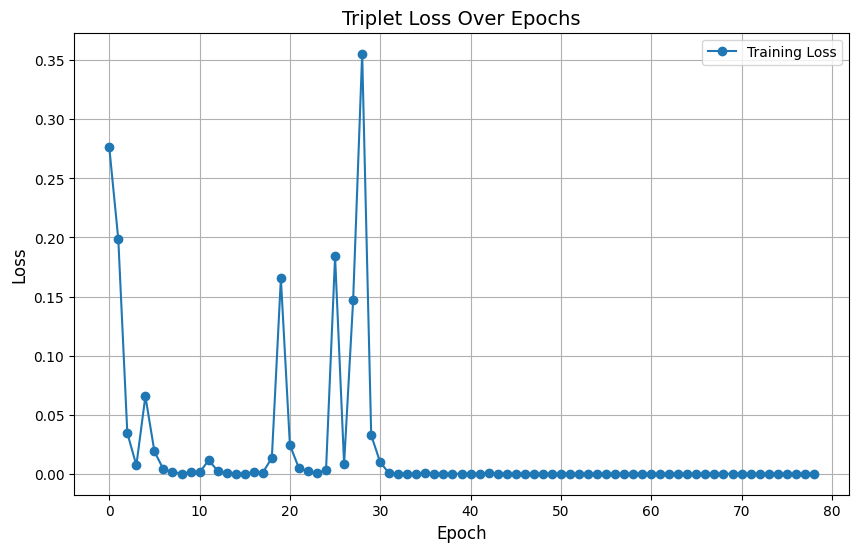

10/10 [==============================] - 25s 3s/step - loss: 0.0000e+00
Epoch 80/100
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00

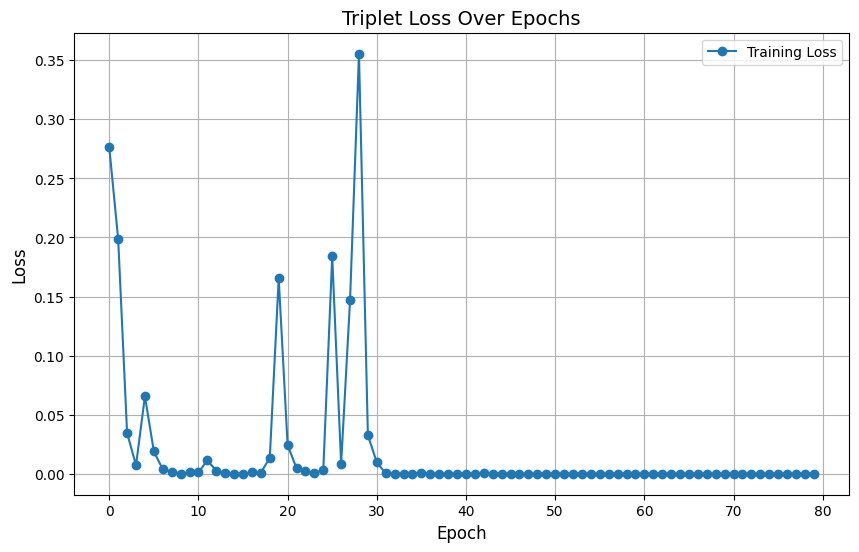

10/10 [==============================] - 24s 2s/step - loss: 0.0000e+00
Epoch 81/100
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00

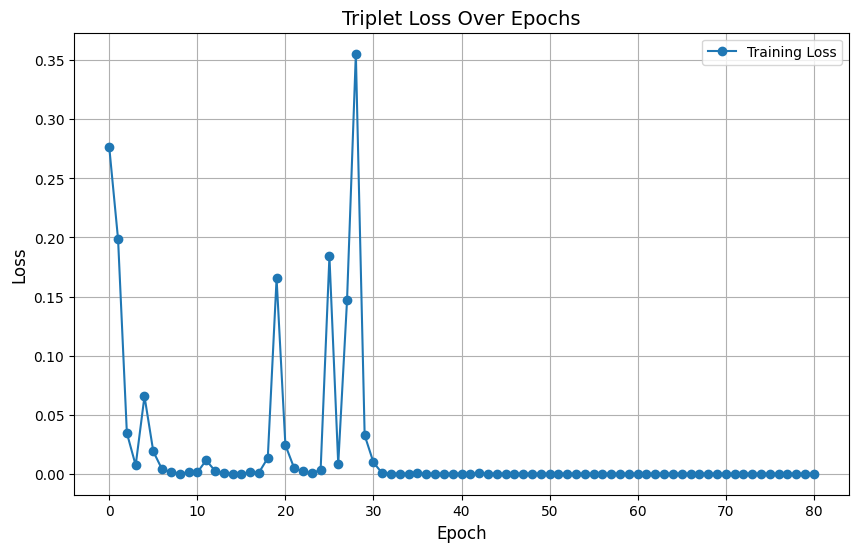

10/10 [==============================] - 26s 3s/step - loss: 0.0000e+00
Epoch 82/100
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00

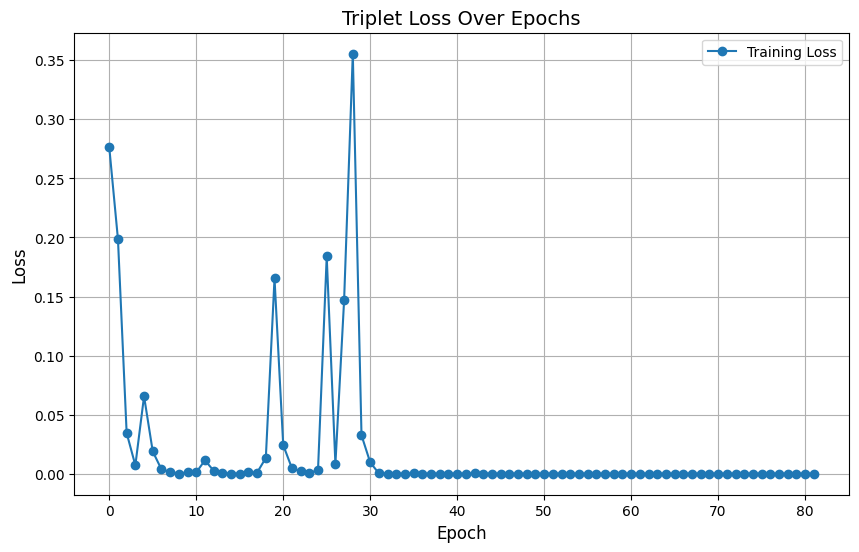

10/10 [==============================] - 26s 3s/step - loss: 0.0000e+00
Epoch 83/100
10/10 [==============================] - ETA: 0s - loss: 1.7702e-04

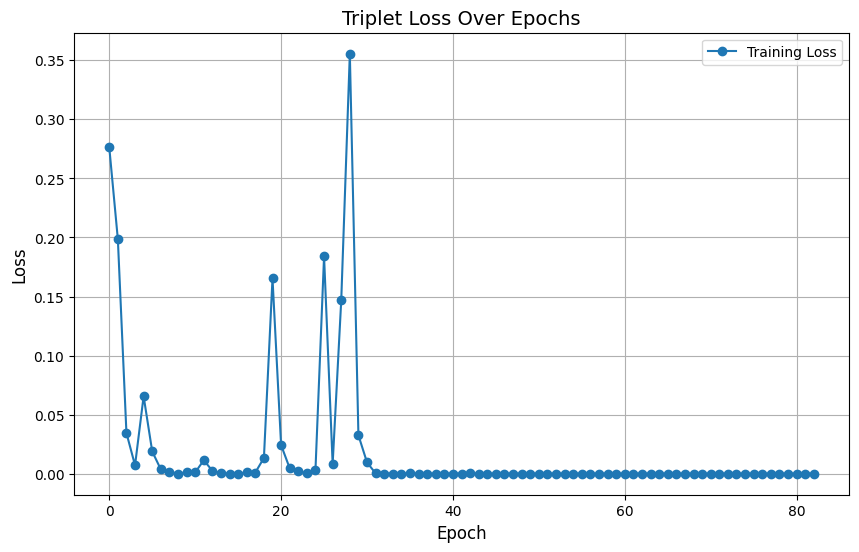

10/10 [==============================] - 25s 3s/step - loss: 1.7702e-04
Epoch 84/100
10/10 [==============================] - ETA: 0s - loss: 8.1570e-05

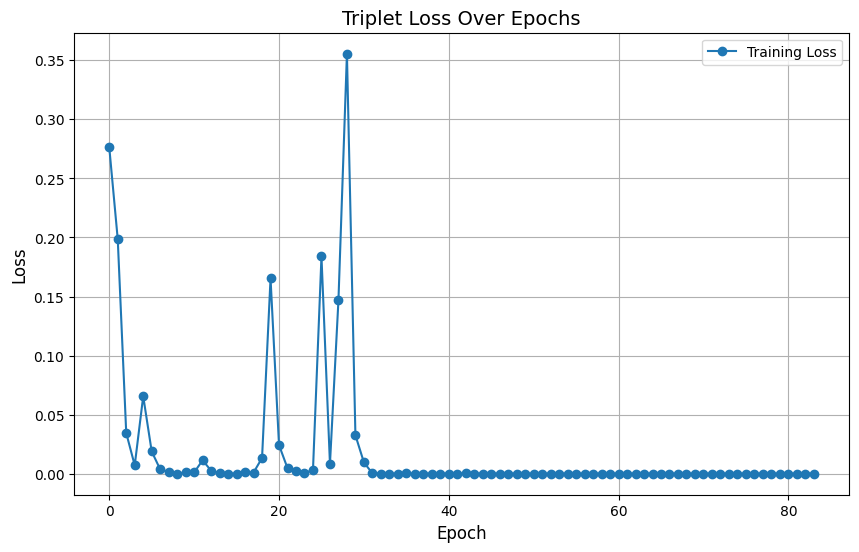

10/10 [==============================] - 25s 3s/step - loss: 8.1570e-05
Epoch 85/100
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00

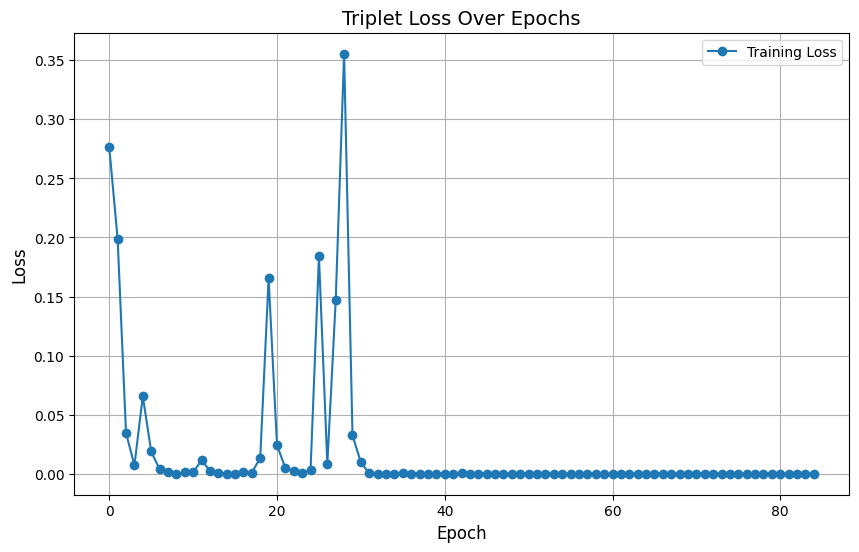

10/10 [==============================] - 25s 3s/step - loss: 0.0000e+00
Epoch 86/100
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00

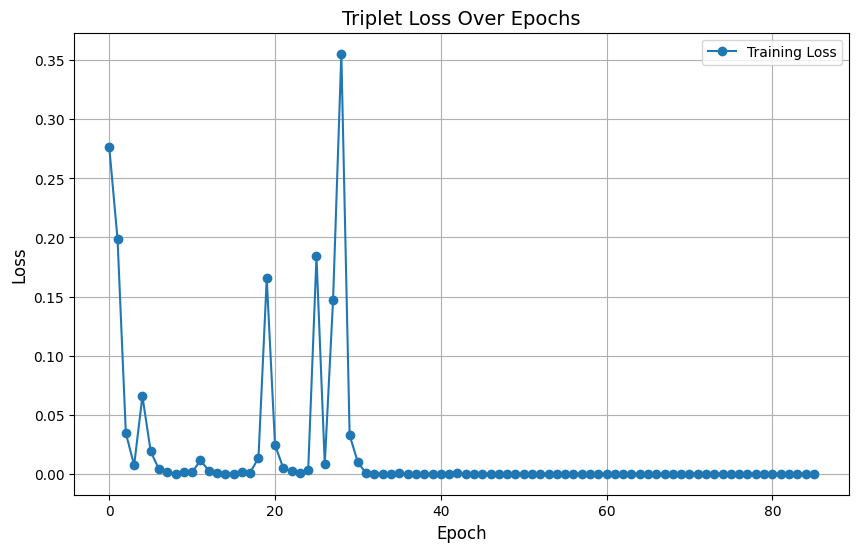

10/10 [==============================] - 24s 2s/step - loss: 0.0000e+00
Epoch 87/100
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00

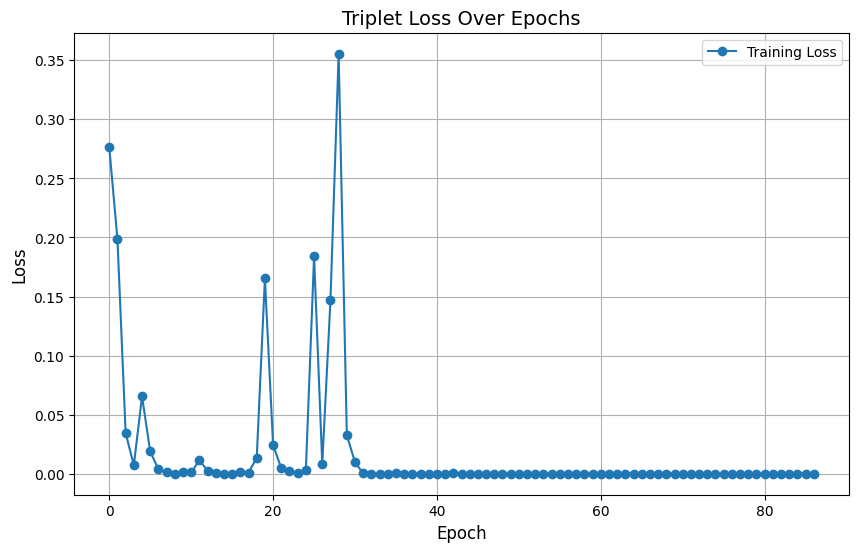

10/10 [==============================] - 26s 3s/step - loss: 0.0000e+00
Epoch 88/100
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00

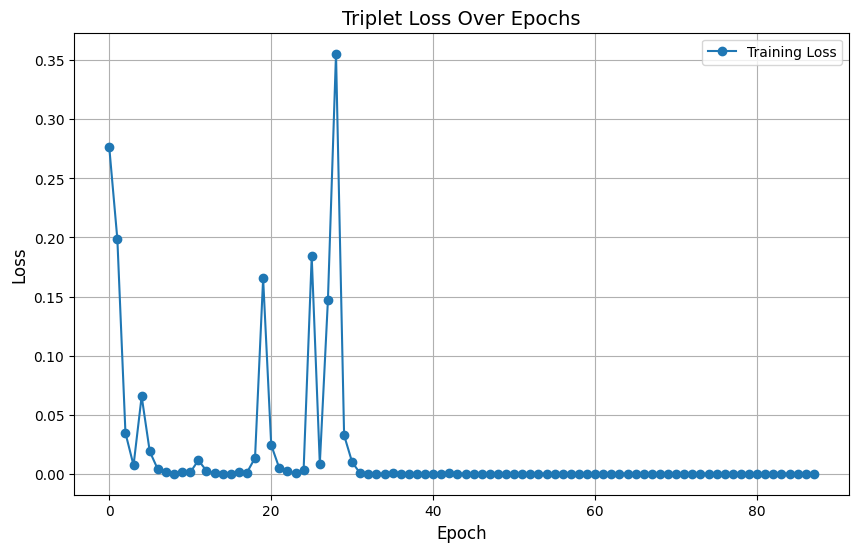

10/10 [==============================] - 25s 3s/step - loss: 0.0000e+00
Epoch 89/100
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00

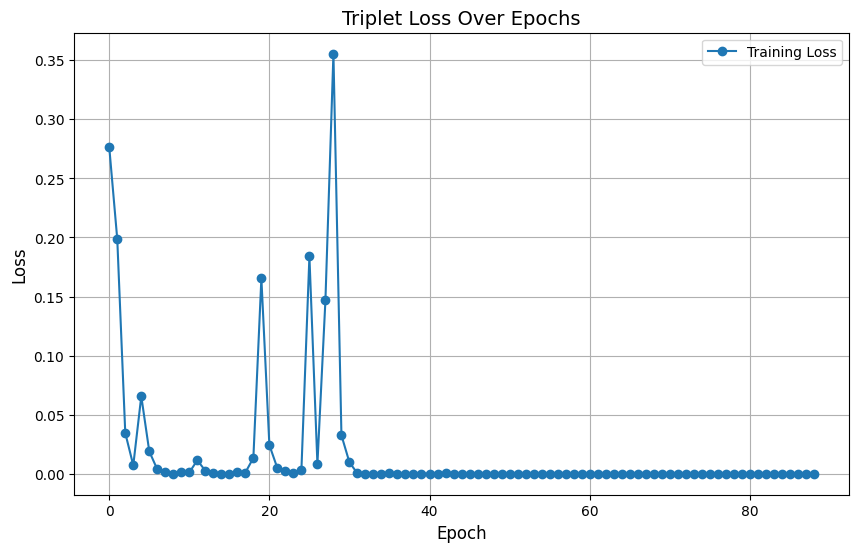

10/10 [==============================] - 26s 3s/step - loss: 0.0000e+00
Epoch 90/100
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00

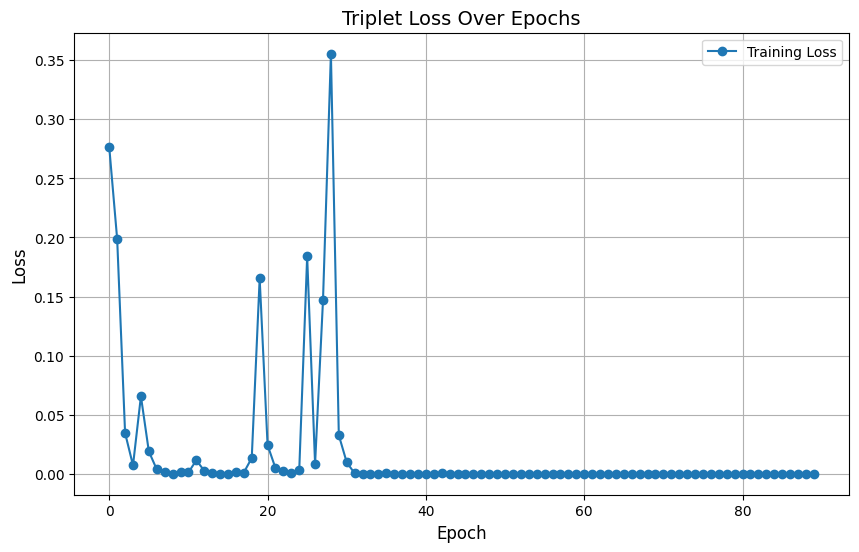

10/10 [==============================] - 24s 2s/step - loss: 0.0000e+00
Epoch 91/100
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00

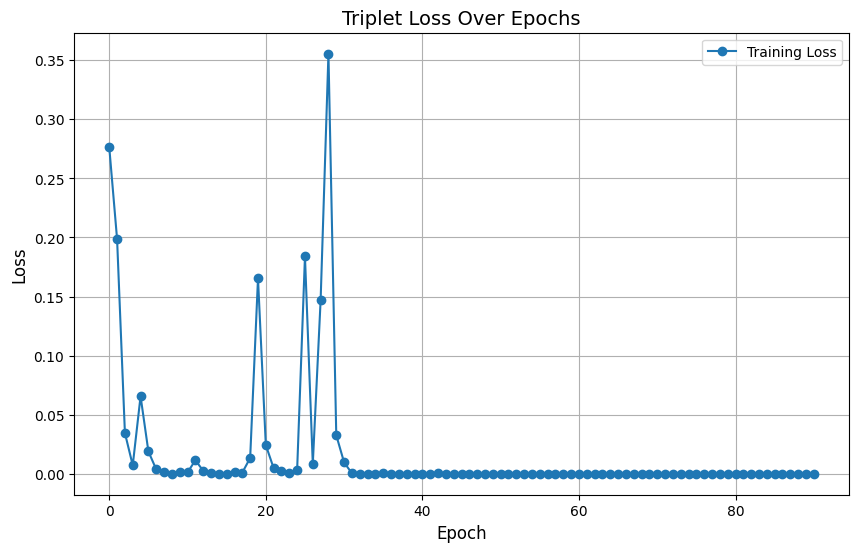

10/10 [==============================] - 26s 3s/step - loss: 0.0000e+00
Epoch 92/100
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00

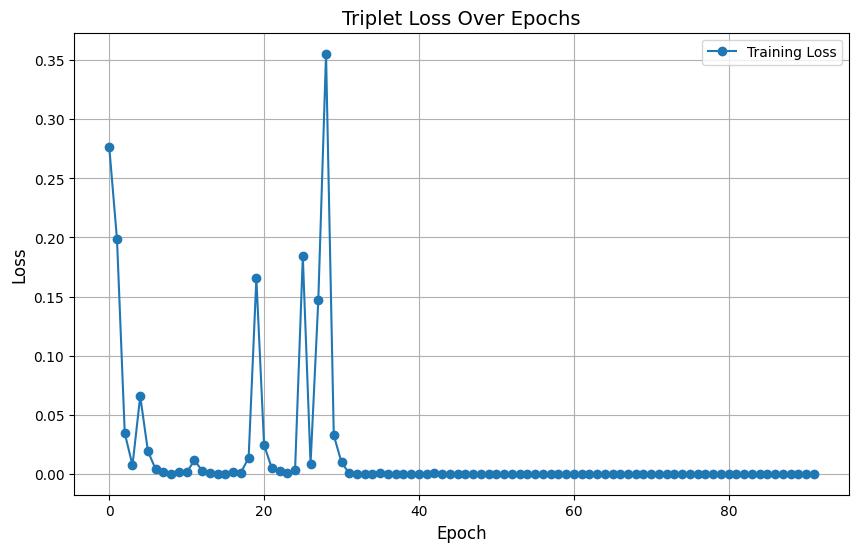

10/10 [==============================] - 26s 3s/step - loss: 0.0000e+00
Epoch 93/100
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00

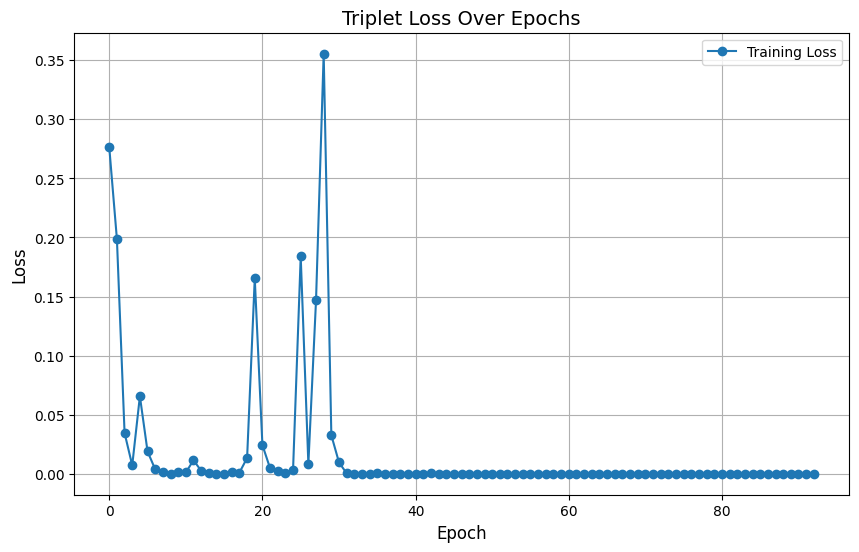

10/10 [==============================] - 26s 3s/step - loss: 0.0000e+00
Epoch 94/100
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00

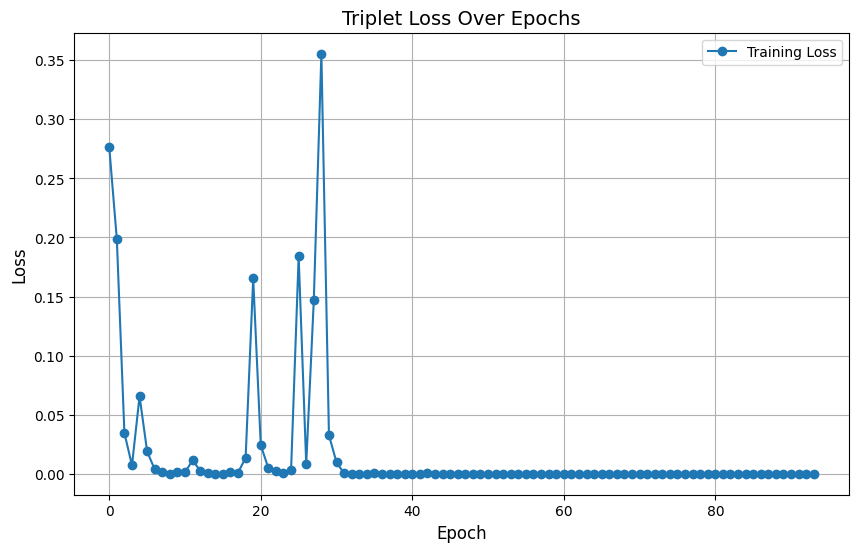

10/10 [==============================] - 24s 2s/step - loss: 0.0000e+00
Epoch 95/100
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00

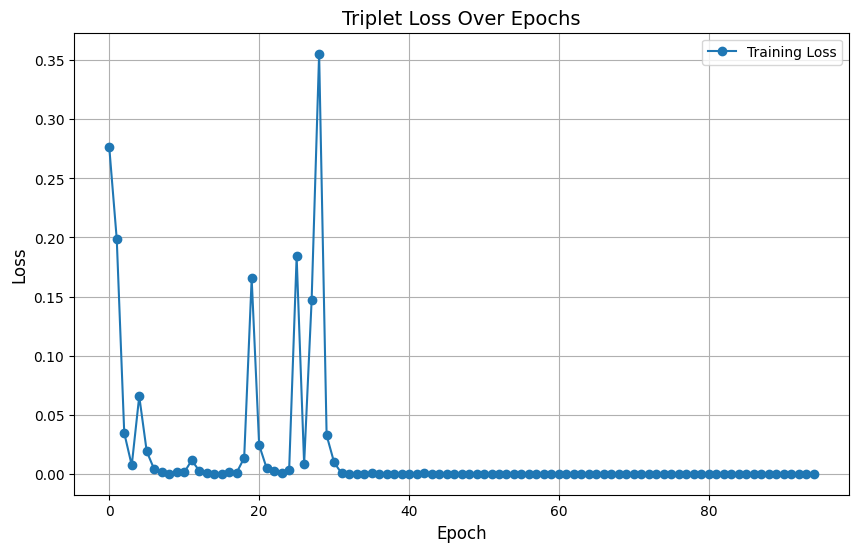

10/10 [==============================] - 26s 3s/step - loss: 0.0000e+00
Epoch 96/100
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00

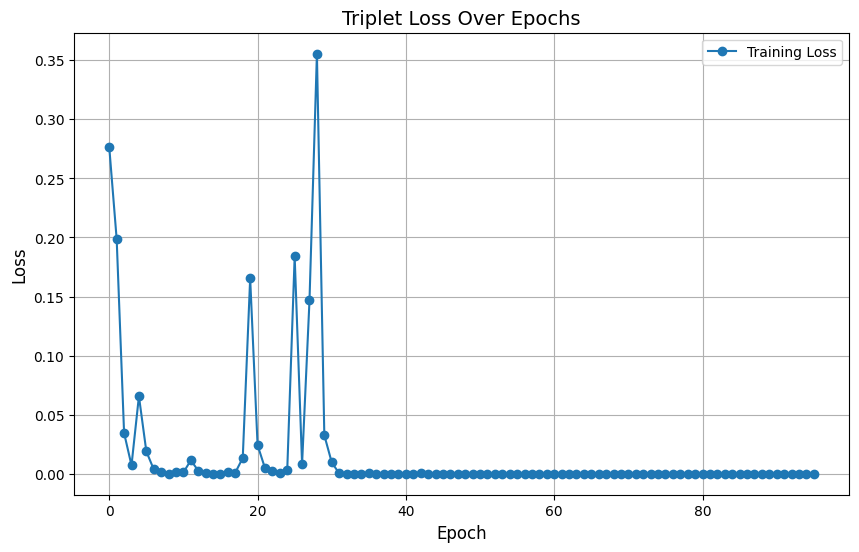

10/10 [==============================] - 26s 3s/step - loss: 0.0000e+00
Epoch 97/100
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00

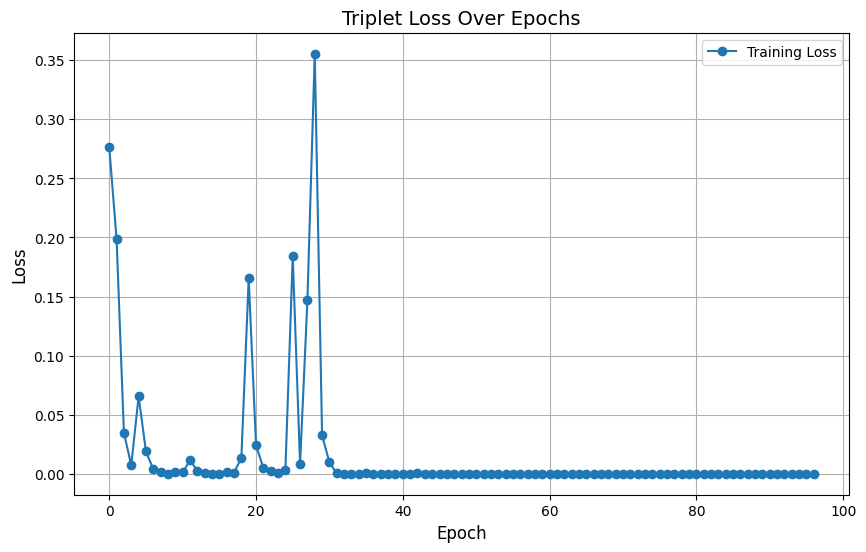

10/10 [==============================] - 26s 3s/step - loss: 0.0000e+00
Epoch 98/100
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00

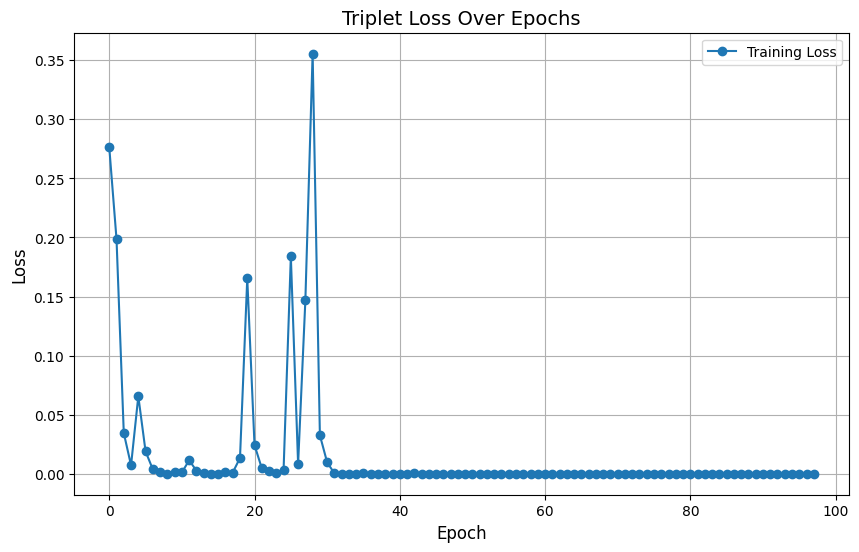

10/10 [==============================] - 24s 2s/step - loss: 0.0000e+00
Epoch 99/100
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00

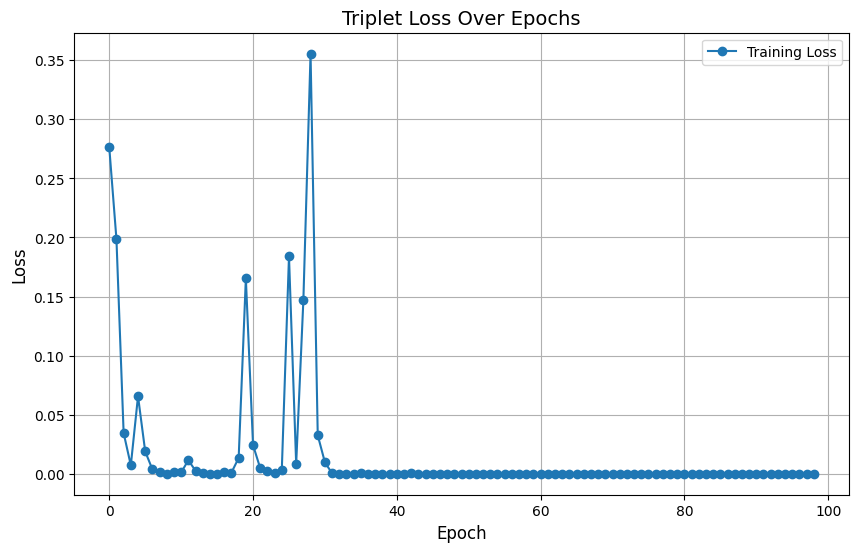

10/10 [==============================] - 25s 2s/step - loss: 0.0000e+00
Epoch 100/100
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00

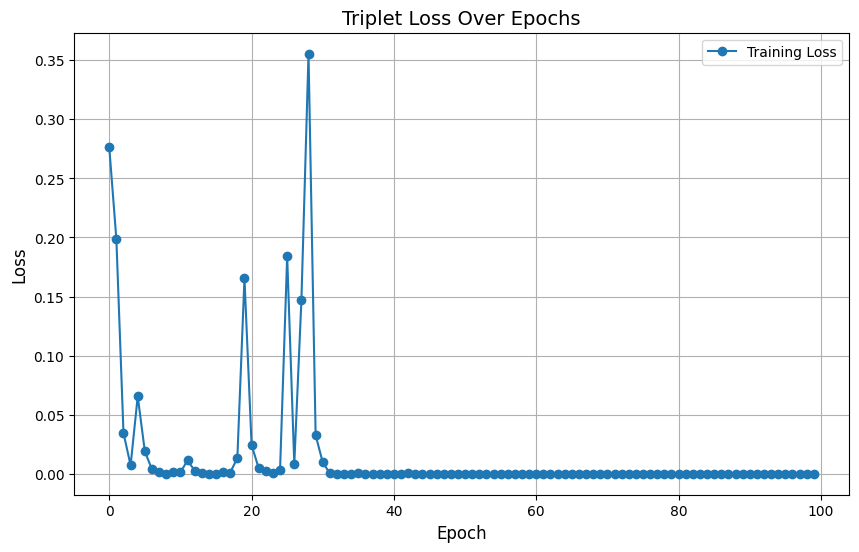

10/10 [==============================] - 25s 3s/step - loss: 0.0000e+00


In [13]:
# ✅ Custom callback for loss visualization
import tensorflow as tf
import matplotlib.pyplot as plt # Make sure to import matplotlib

class PlotLosses(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is None or 'loss' not in logs:
            print("⚠️ Warning: Loss value missing!")
            return

        # Initialize history if it's the first epoch
        if not hasattr(self, 'history'):
            self.history = {'loss': []}

        self.history['loss'].append(logs['loss'])

        plt.figure(figsize=(10, 6))
        plt.plot(self.history['loss'], label='Training Loss', marker='o', linestyle='-')
        plt.title('Triplet Loss Over Epochs', fontsize=14)
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel('Loss', fontsize=12)
        plt.legend()
        plt.grid(True)
        plt.show()

history = triplet_model.fit(
    train_gen,
    epochs=100,
    callbacks=[PlotLosses()]
)

In [14]:
import os
import cv2
import numpy as np
import tensorflow as tf

# ✅ Define IMG_SIZE and photos_dir
IMG_SIZE = 224  # Assuming you're using the same IMG_SIZE throughout
photos_dir = "/content/drive/MyDrive/Namira/CUHK_dataset/Photos" # Assuming this is the correct path

def generate_embeddings(image_paths):
    embeddings = []
    for path in image_paths:
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0
        embedding = embedding_model.predict(np.expand_dims(img, axis=0))
        embeddings.append(embedding)
    return np.array(embeddings)

# Generate and save database embeddings
photo_paths = [os.path.join(photos_dir, f) for f in os.listdir(photos_dir)]
database_embeddings = generate_embeddings(photo_paths)
np.save('database_embeddings.npy', database_embeddings)

# Similarity matching function
def find_similar(query_embedding, database_embeddings, top_k=5):
    distances = tf.norm(database_embeddings - query_embedding, axis=1)
    top_indices = np.argsort(distances)[:top_k]
    return top_indices, distances.numpy()[top_indices]

1/1 [==============================] - 0s 66ms/step


In [16]:
embedding_model.save('/content/sketch_matching_model_optimized.h5')
print("✅ Model saved successfully!")


✅ Model saved successfully!


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 70ms/step


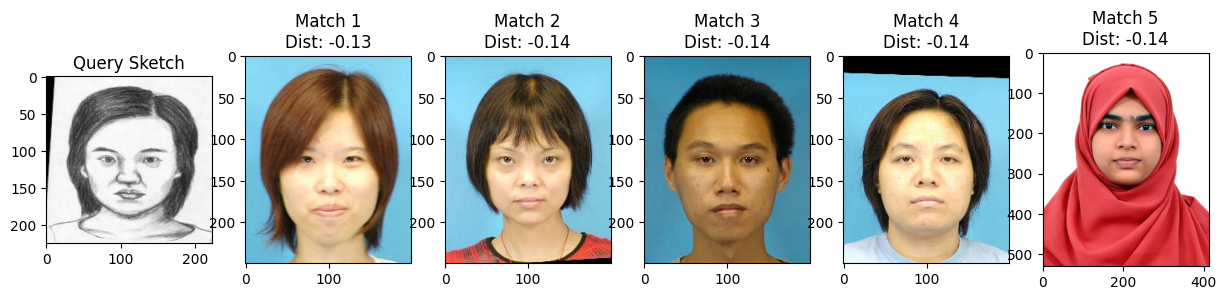

In [18]:
def find_similar(query_embedding, database_embeddings, top_k=5):
    database_embeddings = database_embeddings.squeeze()  # Remove extra dimension
    distances = cosine_similarity(query_embedding, database_embeddings)
    top_indices = np.argsort(distances[0])[-top_k:][::-1]  # Top matches
    return top_indices, distances[0][top_indices]

# Load test image (Replace with actual test image)
test_sketch_path = os.path.join(SKETCHES_DIR, random.choice(os.listdir(SKETCHES_DIR)))
test_sketch = cv2.imread(test_sketch_path)
test_sketch = cv2.cvtColor(test_sketch, cv2.COLOR_BGR2RGB)
test_sketch = cv2.resize(test_sketch, (IMG_SIZE, IMG_SIZE)) / 255.0

# Generate embedding
test_embedding = embedding_model.predict(np.expand_dims(test_sketch, axis=0))

# Load database embeddings
database_embeddings = np.load('/content/database_embeddings.npy')

# Find best matches
top_indices, distances = find_similar(test_embedding, database_embeddings)

# Display results
plt.figure(figsize=(15, 5))
plt.subplot(1, 6, 1)
plt.imshow(test_sketch)
plt.title('Query Sketch')

for i, idx in enumerate(top_indices):
    plt.subplot(1, 6, i+2)
    plt.imshow(cv2.cvtColor(cv2.imread(photo_paths[idx]), cv2.COLOR_BGR2RGB))
    plt.title(f'Match {i+1}\nDist: {distances[i]:.2f}')
plt.show()


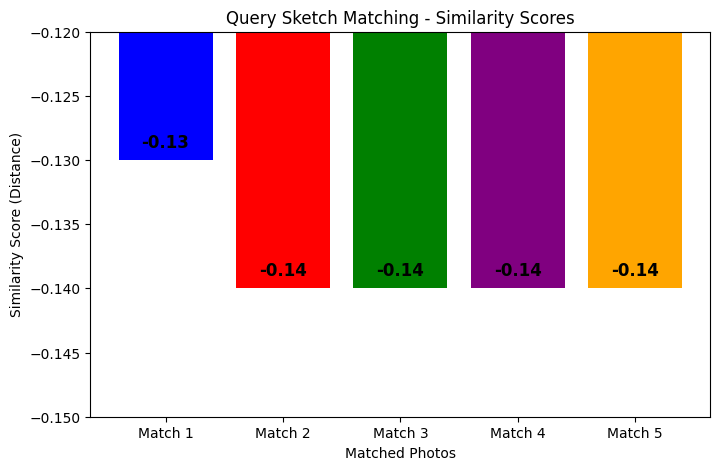

In [30]:
import matplotlib.pyplot as plt

# Match labels
match_labels = ["Match 1", "Match 2", "Match 3", "Match 4", "Match 5"]

# Similarity scores (distance values)
similarity_scores = [-0.13, -0.14, -0.14, -0.14, -0.14]

# Create a figure and axis
plt.figure(figsize=(8, 5))
plt.bar(match_labels, similarity_scores, color=['blue', 'red', 'green', 'purple', 'orange'])

# Labels and title
plt.xlabel("Matched Photos")
plt.ylabel("Similarity Score (Distance)")
plt.title("Query Sketch Matching - Similarity Scores")
plt.ylim(-0.15, -0.12)  # Adjust y-axis to highlight score differences

# Show the values on top of bars
for i, score in enumerate(similarity_scores):
    plt.text(i, score + 0.001, str(score), ha='center', fontsize=12, fontweight='bold')

# Show the graph
plt.show()


In [21]:
print("Available keys in history:", history.history.keys())


Available keys in history: dict_keys(['loss'])


In [22]:
train_acc = history.history.get('accuracy') or history.history.get('sparse_categorical_accuracy')
val_acc = history.history.get('val_accuracy') or history.history.get('val_sparse_categorical_accuracy')
train_loss = history.history['loss']
val_loss = history.history.get('val_loss')


Available keys in history: dict_keys(['loss'])


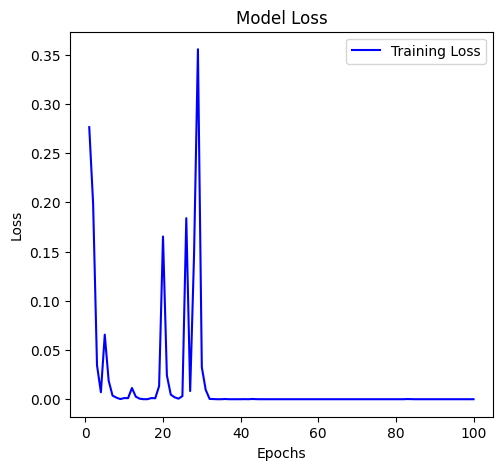

In [24]:
import matplotlib.pyplot as plt

print("Available keys in history:", history.history.keys())  # Debugging step

train_acc = history.history.get('accuracy') or history.history.get('sparse_categorical_accuracy')
val_acc = history.history.get('val_accuracy') or history.history.get('val_sparse_categorical_accuracy')
train_loss = history.history['loss']
val_loss = history.history.get('val_loss')

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

if train_acc:
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
    if val_acc:
        plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
if val_loss:
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()



In [35]:
print("Available keys in history:", history.history.keys())


Available keys in history: dict_keys(['loss'])


In [39]:
print(dir())  # Lists all variables in the script

['BATCH_SIZE', 'DATASET_PATH', 'EMBEDDING_DIM', 'EfficientNetB3', 'FaceNet', 'IMG_SIZE', 'ImageDataGenerator', 'In', 'Model', 'Out', 'PHOTOS_DIR', 'PlotLosses', 'SKETCHES_DIR', 'SketchPhotoGenerator', 'TripletModel', '_', '__', '___', '__builtin__', '__builtins__', '__doc__', '__loader__', '__name__', '__package__', '__spec__', '_dh', '_exit_code', '_i', '_i1', '_i10', '_i11', '_i12', '_i13', '_i14', '_i15', '_i16', '_i17', '_i18', '_i19', '_i2', '_i20', '_i21', '_i22', '_i23', '_i24', '_i25', '_i26', '_i27', '_i28', '_i29', '_i3', '_i30', '_i31', '_i32', '_i33', '_i34', '_i35', '_i36', '_i37', '_i38', '_i39', '_i4', '_i5', '_i6', '_i7', '_i8', '_i9', '_ih', '_ii', '_iii', '_oh', 'axes', 'bar_width', 'batch_photos', 'batch_sketches', 'build_embedding_model', 'correct_matches', 'cosine_similarity', 'create_embedding_model', 'cv2', 'database_embeddings', 'datagen', 'dataset_path', 'directory', 'distances', 'drive', 'embedder', 'embedding_model', 'epochs', 'exit', 'face_encoding_values', 

In [42]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ✅ Define ImageDataGenerator with validation split
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  # 20% for validation

# ✅ Define Training Generator
train_gen = datagen.flow_from_directory(
    "/content/drive/MyDrive/Namira/CUHK_dataset/",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',  # Adjust as needed
    subset='training'  # Training dataset
)

# ✅ Define Validation Generator
val_gen = datagen.flow_from_directory(
    "/content/drive/MyDrive/Namira/CUHK_dataset/",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # Validation dataset
)



Found 310 images belonging to 2 classes.
Found 76 images belonging to 2 classes.


In [52]:
import tensorflow as tf
import numpy as np
import os
import cv2

# ✅ Define dataset directories
PHOTOS_DIR = "/content/drive/MyDrive/Namira/CUHK_dataset/Photos"
SKETCHES_DIR = "/content/drive/MyDrive/Namira/CUHK_dataset/Sketches"

# ✅ Get list of all photo and sketch file paths
photo_paths = np.array([os.path.join(PHOTOS_DIR, f) for f in os.listdir(PHOTOS_DIR) if f.endswith(('.jpg', '.png'))])
sketch_paths = np.array([os.path.join(SKETCHES_DIR, f) for f in os.listdir(SKETCHES_DIR) if f.endswith(('.jpg', '.png'))])

# ✅ Ensure dataset size matches
assert len(photo_paths) == len(sketch_paths), "Mismatch between number of photos and sketches!"

# ✅ Split dataset (80% training, 20% validation)
split_idx = int(0.8 * len(photo_paths))
train_photos, val_photos = photo_paths[:split_idx], photo_paths[split_idx:]
train_sketches, val_sketches = sketch_paths[:split_idx], sketch_paths[split_idx:]

# ✅ Function to load and preprocess images
IMG_SIZE = 224

def load_and_preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)  # Decode image
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])  # Resize to model input size
    img = img / 255.0  # Normalize to [0,1] range
    return img

def load_pair(sketch_path, photo_path):
    sketch = load_and_preprocess_image(sketch_path)  # Input
    photo = load_and_preprocess_image(photo_path)  # Target (Ground Truth)
    return sketch, photo

# ✅ Convert to TensorFlow datasets and map loading function
train_gen = tf.data.Dataset.from_tensor_slices((train_sketches, train_photos))
train_gen = train_gen.map(load_pair).batch(32).shuffle(1000).prefetch(tf.data.AUTOTUNE)

val_gen = tf.data.Dataset.from_tensor_slices((val_sketches, val_photos))
val_gen = val_gen.map(load_pair).batch(32).prefetch(tf.data.AUTOTUNE)


print("Data generators successfully created with image preprocessing!")


Data generators successfully created with image preprocessing!


In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Reshape

# ✅ Create Model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(224 * 224 * 3, activation='sigmoid'),  # Output: Flattened image
    Reshape((224, 224, 3))  # Reshape output to an actual image
])

# ✅ Compile the Model
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

print("✅ Model successfully created and compiled!")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


✅ Model successfully created and compiled!


In [5]:
import tensorflow as tf
import numpy as np
import os

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# ✅ Define dataset directories
PHOTOS_DIR = "/content/drive/MyDrive/Namira/CUHK_dataset/Photos"
SKETCHES_DIR = "/content/drive/MyDrive/Namira/CUHK_dataset/Sketches"

# ✅ Get list of all photo and sketch file paths
photo_paths = np.array([os.path.join(PHOTOS_DIR, f) for f in os.listdir(PHOTOS_DIR) if f.endswith(('.jpg', '.png'))])
sketch_paths = np.array([os.path.join(SKETCHES_DIR, f) for f in os.listdir(SKETCHES_DIR) if f.endswith(('.jpg', '.png'))])

# ✅ Ensure dataset size matches
assert len(photo_paths) == len(sketch_paths), "Mismatch between number of photos and sketches!"

# ✅ Split dataset (80% training, 20% validation)
split_idx = int(0.8 * len(photo_paths))
train_photos, val_photos = photo_paths[:split_idx], photo_paths[split_idx:]
train_sketches, val_sketches = sketch_paths[:split_idx], sketch_paths[split_idx:]

# ✅ Function to load and preprocess images
IMG_SIZE = 224

def load_and_preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)  # Decode image
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])  # Resize to model input size
    img = img / 255.0  # Normalize to [0,1] range
    return img

def load_pair(sketch_path, photo_path):
    sketch = load_and_preprocess_image(sketch_path)
    photo = load_and_preprocess_image(photo_path)
    return sketch, photo

# ✅ Convert to TensorFlow datasets and map loading function
train_gen = tf.data.Dataset.from_tensor_slices((train_sketches, train_photos))
train_gen = train_gen.map(load_pair).batch(32).shuffle(1000).prefetch(tf.data.AUTOTUNE)

val_gen = tf.data.Dataset.from_tensor_slices((val_sketches, val_photos))
val_gen = val_gen.map(load_pair).batch(32).prefetch(tf.data.AUTOTUNE)

print("✅ Data generators successfully created with image preprocessing!")


Mounted at /content/drive
✅ Data generators successfully created with image preprocessing!


In [6]:
history = model.fit(train_gen, epochs=50, verbose=1, validation_data=val_gen)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 71s 9s/step - accuracy: 0.3761 - loss: 0.0860 - val_accuracy: 0.7357 - val_loss: 0.0681
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 49s 7s/step - accuracy: 0.6914 - loss: 0.0454 - val_accuracy: 0.7818 - val_loss: 0.0555
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 39s 7s/step - accuracy: 0.7735 - loss: 0.0462 - val_accuracy: 0.7964 - val_loss: 0.0592
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 34s 6s/step - accuracy: 0.8182 - loss: 0.0367 - val_accuracy: 0.8049 - val_loss: 0.0533
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 37s 7s/step - accuracy: 0.8245 - loss: 0.0384 - val_accuracy: 0.8061 - val_loss: 0.0574
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 36s 6s/step - accuracy: 0.8206 - loss: 0.0405 - val_accuracy: 0.8086 - val_loss: 0.0542
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 33s 6s/step - accuracy: 0.8374 - loss: 0.0351 - val_accuracy: 0.8113 - val_loss: 0.0534
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 33s 6s/step - accuracy: 0.8477 - loss: 0.0344 - val_accuracy: 0.8129 - val_loss: 0.0534
Epoch 9/

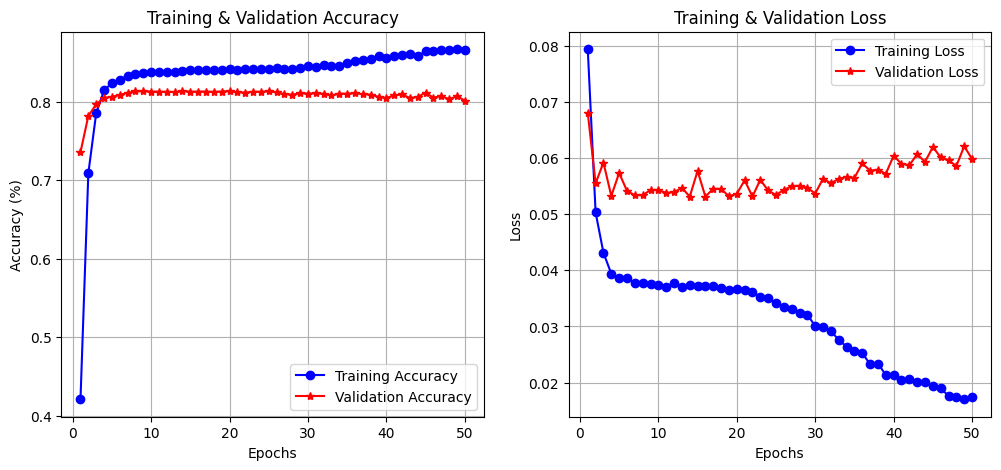

In [7]:
import matplotlib.pyplot as plt

# Extract loss & accuracy
train_loss = history.history['loss']
val_loss = history.history.get('val_loss')
train_acc = history.history.get('accuracy')
val_acc = history.history.get('val_accuracy')

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

# 📈 Accuracy Graph
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r*-', label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# 📉 Loss Graph
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()
